In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector,Input
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from keras.utils import to_categorical
%matplotlib inline

Using TensorFlow backend.
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\user10\Anaconda3\envs\P

In [189]:
df = pd.read_csv('./data/data_2.csv')
df = df.drop(['Pid', 'm_b', 'pred1'], axis=1)
df = df.drop([0])
df = df.reset_index(drop = True)
df = df.drop(['b21_diff_abs'], axis = 1)
df

,DealPrice,DealQty,BidQty1,Bid1,Ask1,AskQty1,BidQty2,Bid2,Ask2,AskQty2,...,daq1_dt,daq2_dt,daq3_dt,daq4_dt,daq5_dt,dbq1_dt,dbq2_dt,dbq3_dt,dbq4_dt,dbq5_dt
0,127.0,2,60,126.5,127.0,108,78,126.0,127.5,36,...,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,127.0,6,62,126.5,127.0,102,79,126.0,127.5,41,...,-6.0,5.0,0.0,0.0,5.0,2.0,1.0,0.0,0.0,5.0
2,127.0,7,63,126.5,127.0,102,78,126.0,127.5,40,...,0.0,-1.0,0.0,0.0,1.0,1.0,-1.0,0.0,0.0,0.0
3,127.0,7,93,126.5,127.0,103,78,126.0,127.5,41,...,1.0,1.0,0.0,-1.0,0.0,30.0,0.0,0.0,0.0,0.0
4,127.0,102,92,126.5,127.0,8,78,126.0,127.5,41,...,-95.0,0.0,0.0,0.0,-1.0,-1.0,0.0,6.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253054,130.5,1,212,130.0,130.5,22,142,129.5,131.0,24,...,-1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
253055,0.0,0,213,130.0,130.5,22,142,129.5,131.0,24,...,0.0,0.0,-4.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.0
253056,0.0,0,213,130.0,130.5,15,142,129.5,131.0,25,...,-7.0,1.0,0.0,-4.0,0.0,0.0,0.0,-4.0,-10.0,1.0
253057,130.5,1,213,130.0,130.5,14,142,129.5,131.0,26,...,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0


In [3]:
#df['mid1'] = (df['Ask1'] + df['Bid1']) / 2
#df = df.reset_index(drop = True)
#df = df.drop([0, 253059])
#df = df.reset_index(drop = True)
#df = df.drop(['next_mid1'], axis = 1)
#因為b21_diff_abs這個col剛好都為同一個值 -> drop 
#df = df.drop(['b21_diff_abs'], axis = 1)
#df = df.drop(['TxTime'], axis = 1)
#df

,BidQty1,Bid1,Ask1,AskQty1,BidQty2,Bid2,Ask2,AskQty2,BidQty3,Bid3,...,daq2_dt,daq3_dt,daq4_dt,daq5_dt,dbq1_dt,dbq2_dt,dbq3_dt,dbq4_dt,dbq5_dt,mid1
0,60,126.5,127.0,108,78,126.0,127.5,36,53,125.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,126.75
1,62,126.5,127.0,102,79,126.0,127.5,41,53,125.5,...,5.0,0.0,0.0,5.0,2.0,1.0,0.0,0.0,5.0,126.75
2,63,126.5,127.0,102,78,126.0,127.5,40,53,125.5,...,-1.0,0.0,0.0,1.0,1.0,-1.0,0.0,0.0,0.0,126.75
3,93,126.5,127.0,103,78,126.0,127.5,41,53,125.5,...,1.0,0.0,-1.0,0.0,30.0,0.0,0.0,0.0,0.0,126.75
4,92,126.5,127.0,8,78,126.0,127.5,41,59,125.5,...,0.0,0.0,0.0,-1.0,-1.0,0.0,6.0,1.0,0.0,126.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253053,212,130.0,130.5,23,142,129.5,131.0,24,316,129.0,...,-2.0,0.0,0.0,0.0,-4.0,0.0,0.0,0.0,-1.0,130.25
253054,212,130.0,130.5,22,142,129.5,131.0,24,316,129.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,130.25
253055,213,130.0,130.5,22,142,129.5,131.0,24,316,129.0,...,0.0,-4.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.0,130.25
253056,213,130.0,130.5,15,142,129.5,131.0,25,312,129.0,...,1.0,0.0,-4.0,0.0,0.0,0.0,-4.0,-10.0,1.0,130.25


In [4]:
#normalize
def normalize(df):
    norm = df.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
    return norm
#scale back to the true range
def true_range(df, x):
    X = (x * (df['mid1'].max() - df['mid1'].min())) + df['mid1'].min()
    return X
#rolling windows
def train_windows(df, ref_day=5, predict_day=1):
    X_train, Y_train = [], []
    for i in range(df.shape[0]-predict_day-ref_day):
        X_train.append(np.array(df.iloc[i:i+ref_day,:-1]))
        Y_train.append(np.array(df.iloc[i+ref_day:i+ref_day+predict_day]["mid1"]))
    return np.array(X_train), np.array(Y_train)
#LSTM (when add the drop out layer in order to deal with overfitting)
def lstm_stock_model(shape):
    model = Sequential()
    #return sequence = True -> means the network will have long memory
    model.add(LSTM(256, input_shape=(shape[1], shape[2]), return_sequences=True))
    model.add(LSTM(256, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(1)))
    model.add(Flatten())
    model.add(Dense(5,activation='linear'))
    model.add(Dense(1,activation='linear'))
    model.compile(loss="mean_absolute_error", optimizer="adam",metrics=['mean_absolute_error'])
    model.summary()
    return model

In [5]:
#adjust the parameters in lstm
batch_size = [128, 256, 512]
validation_split = [0.1, 0.2, 0.3]

In [190]:
#normalize
norm_df = normalize(df)
#train test split
test = norm_df[-round(df.shape[0]*0.3):]
test = test.reset_index(drop = True)
train = norm_df[:round(df.shape[0]*0.7)]

In [191]:
#10 days forecast next day
X_train, Y_train = train_windows(train, 10, 1)
X_test, Y_test = train_windows(test, 10, 1)

In [109]:
#adding drop out layer(pct = 0.5)
#batch size = 256
#validation split = 0.2 (not letting val loss < loss)
#early stop -> val loss patience = 10
model_1 = lstm_stock_model(X_train.shape)
callback = EarlyStopping(monitor="val_mean_absolute_error", patience=10, verbose=1, mode="min")
history_1 = model_1.fit(X_train, Y_train, epochs=500, batch_size=batch_size[1], validation_split=validation_split[1], callbacks=[callback], shuffle=True)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 10, 256)           330752    
_________________________________________________________________
lstm_6 (LSTM)                (None, 10, 256)           525312    
_________________________________________________________________
dropout_3 (Dropout)          (None, 10, 256)           0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 10, 1)             257       
_________________________________________________________________
flatten_3 (Flatten)          (None, 10)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

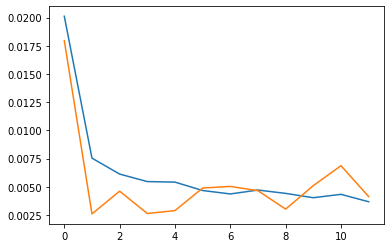

In [110]:
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])

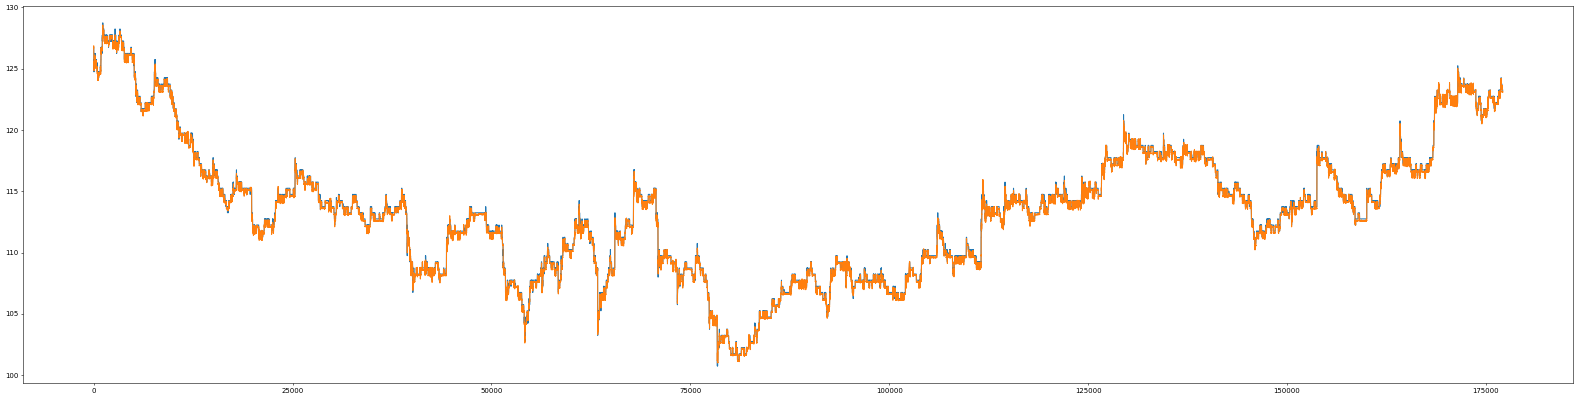

In [192]:
#train error
X_t = model_1.predict(X_train)
plt.figure(figsize=(40,10),dpi=50)
plt.plot(true_range(df, Y_train))
plt.plot(true_range(df, X_t))

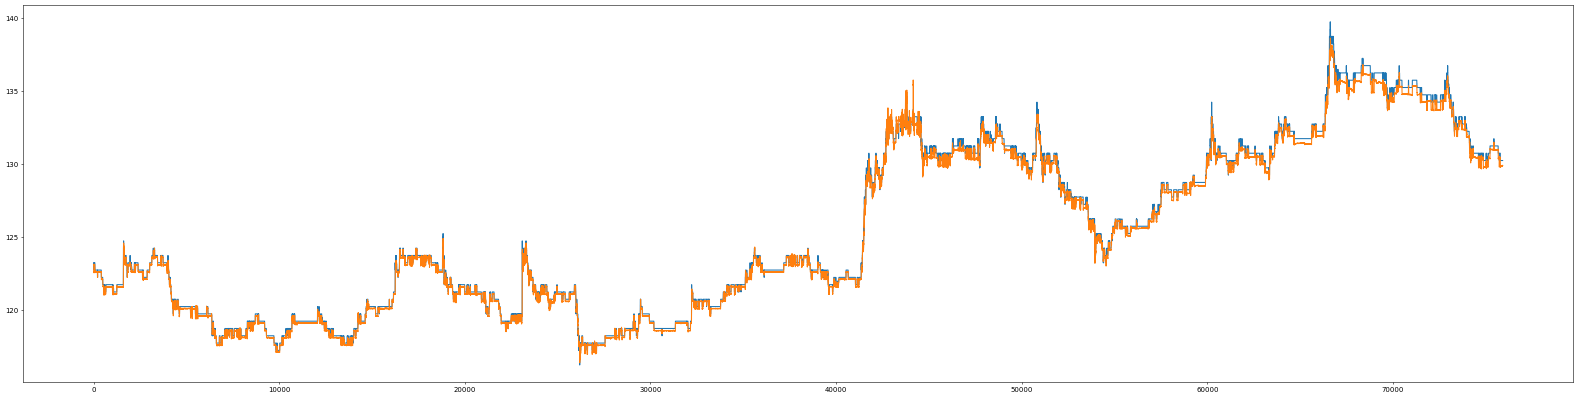

In [193]:
#test error
Xt = model_1.predict(X_test)
plt.figure(figsize=(40,10),dpi=50)
plt.plot(true_range(df, Y_test))
plt.plot(true_range(df, Xt))

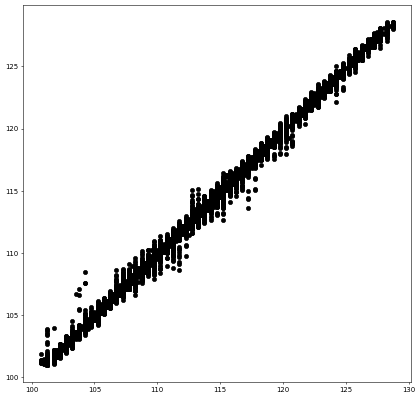

In [113]:
#train error scatter plot
plt.figure(figsize=(10,10),dpi=50)
plt.scatter(true_range(df, Y_train), true_range(df, X_t), color = ['black'])

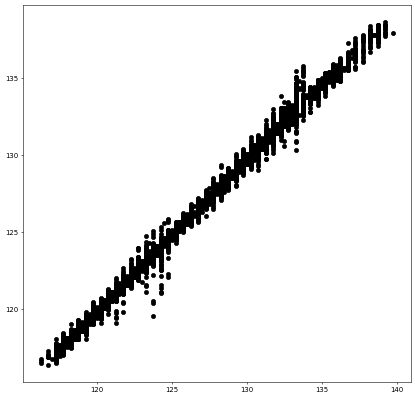

In [114]:
#test error scatter plot
plt.figure(figsize=(10,10),dpi=50)
plt.scatter(true_range(df, Y_test), true_range(df, Xt), color = ['black'])

In [194]:
#fill deal price =0 with t-1 deal price
df_ = df
df_['Price'] = df_['DealPrice']
idx = [i for i, e in enumerate(df_['Price']) if e == 0]
for i in idx:
    df_['Price'].iloc[i] = df_['Price'].iloc[i - 1]
#test set
df_test = df_[-round(df_.shape[0]*0.3):]
df_test

C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,DealPrice,DealQty,BidQty1,Bid1,Ask1,AskQty1,BidQty2,Bid2,Ask2,AskQty2,...,daq2_dt,daq3_dt,daq4_dt,daq5_dt,dbq1_dt,dbq2_dt,dbq3_dt,dbq4_dt,dbq5_dt,Price
177141,0.0,0,59,123.0,123.5,50,140,122.5,124.0,157,...,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,123.0
177142,0.0,0,60,123.0,123.5,50,140,122.5,124.0,157,...,0.0,1.0,-2.0,0.0,1.0,0.0,0.0,0.0,0.0,123.0
177143,0.0,0,60,123.0,123.5,50,140,122.5,124.0,158,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,123.0
177144,123.0,1,59,123.0,123.5,51,140,122.5,124.0,158,...,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,123.0
177145,0.0,0,60,123.0,123.5,51,140,122.5,124.0,158,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,123.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253054,130.5,1,212,130.0,130.5,22,142,129.5,131.0,24,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,130.5
253055,0.0,0,213,130.0,130.5,22,142,129.5,131.0,24,...,0.0,-4.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.0,130.5
253056,0.0,0,213,130.0,130.5,15,142,129.5,131.0,25,...,1.0,0.0,-4.0,0.0,0.0,0.0,-4.0,-10.0,1.0,130.5
253057,130.5,1,213,130.0,130.5,14,142,129.5,131.0,26,...,1.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0,130.5


In [116]:
true_range(df, Xt).shape

(75907, 1)

In [117]:
true_range(df, Y_test).shape

(75907, 1)

In [118]:
Xt.shape

(75907, 1)

In [119]:
Y_test.shape

(75907, 1)

In [195]:
df_test = df_test.iloc[11:, :]
df_test

,DealPrice,DealQty,BidQty1,Bid1,Ask1,AskQty1,BidQty2,Bid2,Ask2,AskQty2,...,daq2_dt,daq3_dt,daq4_dt,daq5_dt,dbq1_dt,dbq2_dt,dbq3_dt,dbq4_dt,dbq5_dt,Price
177152,123.5,1,60,123.0,123.5,64,140,122.5,124.0,158,...,0.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,0.0,123.5
177153,0.0,0,60,123.0,123.5,64,140,122.5,124.0,160,...,2.0,0.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,123.5
177154,0.0,0,60,123.0,123.5,66,140,122.5,124.0,160,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,123.5
177155,0.0,0,60,123.0,123.5,66,140,122.5,124.0,160,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,123.5
177156,123.0,1,59,123.0,123.5,66,143,122.5,124.0,160,...,0.0,1.0,0.0,0.0,-1.0,3.0,0.0,0.0,0.0,123.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253054,130.5,1,212,130.0,130.5,22,142,129.5,131.0,24,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,130.5
253055,0.0,0,213,130.0,130.5,22,142,129.5,131.0,24,...,0.0,-4.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.0,130.5
253056,0.0,0,213,130.0,130.5,15,142,129.5,131.0,25,...,1.0,0.0,-4.0,0.0,0.0,0.0,-4.0,-10.0,1.0,130.5
253057,130.5,1,213,130.0,130.5,14,142,129.5,131.0,26,...,1.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0,130.5


In [196]:
df_test['pred_mid1'] = true_range(df, Xt)
df_test['pred_mid1_shift'] = df_test['pred_mid1'].shift(1)
df_test

C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,DealPrice,DealQty,BidQty1,Bid1,Ask1,AskQty1,BidQty2,Bid2,Ask2,AskQty2,...,daq4_dt,daq5_dt,dbq1_dt,dbq2_dt,dbq3_dt,dbq4_dt,dbq5_dt,Price,pred_mid1,pred_mid1_shift
177152,123.5,1,60,123.0,123.5,64,140,122.5,124.0,158,...,1.0,0.0,0.0,0.0,2.0,1.0,0.0,123.5,123.115417,NaN
177153,0.0,0,60,123.0,123.5,64,140,122.5,124.0,160,...,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,123.5,123.105072,123.115417
177154,0.0,0,60,123.0,123.5,66,140,122.5,124.0,160,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,123.5,123.110718,123.105072
177155,0.0,0,60,123.0,123.5,66,140,122.5,124.0,160,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,123.5,123.123291,123.110718
177156,123.0,1,59,123.0,123.5,66,143,122.5,124.0,160,...,0.0,0.0,-1.0,3.0,0.0,0.0,0.0,123.0,123.101425,123.123291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253054,130.5,1,212,130.0,130.5,22,142,129.5,131.0,24,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,130.5,129.913315,129.910843
253055,0.0,0,213,130.0,130.5,22,142,129.5,131.0,24,...,0.0,0.0,1.0,0.0,0.0,0.0,-1.0,130.5,129.921112,129.913315
253056,0.0,0,213,130.0,130.5,15,142,129.5,131.0,25,...,-4.0,0.0,0.0,0.0,-4.0,-10.0,1.0,130.5,129.913559,129.921112
253057,130.5,1,213,130.0,130.5,14,142,129.5,131.0,26,...,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0,130.5,129.914276,129.913559


In [199]:
df_test = df_test.drop([177152])
df_test

,DealPrice,DealQty,BidQty1,Bid1,Ask1,AskQty1,BidQty2,Bid2,Ask2,AskQty2,...,daq4_dt,daq5_dt,dbq1_dt,dbq2_dt,dbq3_dt,dbq4_dt,dbq5_dt,Price,pred_mid1,pred_mid1_shift
177153,0.0,0,60,123.0,123.5,64,140,122.5,124.0,160,...,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,123.5,123.105072,123.115417
177154,0.0,0,60,123.0,123.5,66,140,122.5,124.0,160,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,123.5,123.110718,123.105072
177155,0.0,0,60,123.0,123.5,66,140,122.5,124.0,160,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,123.5,123.123291,123.110718
177156,123.0,1,59,123.0,123.5,66,143,122.5,124.0,160,...,0.0,0.0,-1.0,3.0,0.0,0.0,0.0,123.0,123.101425,123.123291
177157,123.0,1,58,123.0,123.5,66,143,122.5,124.0,160,...,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,123.0,123.117615,123.101425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253054,130.5,1,212,130.0,130.5,22,142,129.5,131.0,24,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,130.5,129.913315,129.910843
253055,0.0,0,213,130.0,130.5,22,142,129.5,131.0,24,...,0.0,0.0,1.0,0.0,0.0,0.0,-1.0,130.5,129.921112,129.913315
253056,0.0,0,213,130.0,130.5,15,142,129.5,131.0,25,...,-4.0,0.0,0.0,0.0,-4.0,-10.0,1.0,130.5,129.913559,129.921112
253057,130.5,1,213,130.0,130.5,14,142,129.5,131.0,26,...,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0,130.5,129.914276,129.913559


In [200]:
df_test['pred_return'] = (df_test['pred_mid1'] / df_test['pred_mid1_shift']) - 1
df_test

,DealPrice,DealQty,BidQty1,Bid1,Ask1,AskQty1,BidQty2,Bid2,Ask2,AskQty2,...,daq5_dt,dbq1_dt,dbq2_dt,dbq3_dt,dbq4_dt,dbq5_dt,Price,pred_mid1,pred_mid1_shift,pred_return
177153,0.0,0,60,123.0,123.5,64,140,122.5,124.0,160,...,0.0,0.0,0.0,0.0,0.0,0.0,123.5,123.105072,123.115417,-0.000084
177154,0.0,0,60,123.0,123.5,66,140,122.5,124.0,160,...,0.0,0.0,0.0,0.0,0.0,0.0,123.5,123.110718,123.105072,0.000046
177155,0.0,0,60,123.0,123.5,66,140,122.5,124.0,160,...,0.0,0.0,0.0,0.0,0.0,0.0,123.5,123.123291,123.110718,0.000102
177156,123.0,1,59,123.0,123.5,66,143,122.5,124.0,160,...,0.0,-1.0,3.0,0.0,0.0,0.0,123.0,123.101425,123.123291,-0.000178
177157,123.0,1,58,123.0,123.5,66,143,122.5,124.0,160,...,0.0,-1.0,0.0,0.0,0.0,0.0,123.0,123.117615,123.101425,0.000131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253054,130.5,1,212,130.0,130.5,22,142,129.5,131.0,24,...,0.0,0.0,0.0,0.0,0.0,1.0,130.5,129.913315,129.910843,0.000019
253055,0.0,0,213,130.0,130.5,22,142,129.5,131.0,24,...,0.0,1.0,0.0,0.0,0.0,-1.0,130.5,129.921112,129.913315,0.000060
253056,0.0,0,213,130.0,130.5,15,142,129.5,131.0,25,...,0.0,0.0,0.0,-4.0,-10.0,1.0,130.5,129.913559,129.921112,-0.000058
253057,130.5,1,213,130.0,130.5,14,142,129.5,131.0,26,...,0.0,0.0,0.0,-1.0,0.0,-1.0,130.5,129.914276,129.913559,0.000005


In [201]:
df_test['pred_return'].describe()

count    7.590600e+04
mean     8.430147e-07
std      5.207169e-04
min     -1.340228e-02
25%     -8.285046e-05
50%     -1.192093e-07
75%      8.404255e-05
max      1.419997e-02
Name: pred_return, dtype: float64

In [160]:
df_test['Price'].describe()

count    75907.000000
mean       125.401880
std          5.748781
min        116.500000
25%        120.500000
50%        123.500000
75%        130.500000
max        139.500000
Name: Price, dtype: float64

In [161]:
df_test['pred_mid1'].describe()

count    75907.000000
mean       125.213409
std          5.649500
min        116.407280
25%        120.119961
50%        123.133957
75%        130.493111
max        138.629456
Name: pred_mid1, dtype: float64

In [214]:
np.sum(df_test['pred_return'] > 0.001)

2630

In [215]:
np.sum(df_test['pred_return'] < -0.001)

2624

In [204]:
df_test['Price_shift'] = df_test['Price'].shift(1)
df_test['Price_shift'] = df_test['Price_shift'].fillna(123.5)
df_test['actual_return'] = (df_test['Price'] / df_test['Price_shift']) - 1
df_test = df_test.reset_index(drop = True)
df_test

,DealPrice,DealQty,BidQty1,Bid1,Ask1,AskQty1,BidQty2,Bid2,Ask2,AskQty2,...,dbq2_dt,dbq3_dt,dbq4_dt,dbq5_dt,Price,pred_mid1,pred_mid1_shift,pred_return,Price_shift,actual_return
0,0.0,0,60,123.0,123.5,64,140,122.5,124.0,160,...,0.0,0.0,0.0,0.0,123.5,123.105072,123.115417,-0.000084,123.5,0.000000
1,0.0,0,60,123.0,123.5,66,140,122.5,124.0,160,...,0.0,0.0,0.0,0.0,123.5,123.110718,123.105072,0.000046,123.5,0.000000
2,0.0,0,60,123.0,123.5,66,140,122.5,124.0,160,...,0.0,0.0,0.0,0.0,123.5,123.123291,123.110718,0.000102,123.5,0.000000
3,123.0,1,59,123.0,123.5,66,143,122.5,124.0,160,...,3.0,0.0,0.0,0.0,123.0,123.101425,123.123291,-0.000178,123.5,-0.004049
4,123.0,1,58,123.0,123.5,66,143,122.5,124.0,160,...,0.0,0.0,0.0,0.0,123.0,123.117615,123.101425,0.000131,123.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75901,130.5,1,212,130.0,130.5,22,142,129.5,131.0,24,...,0.0,0.0,0.0,1.0,130.5,129.913315,129.910843,0.000019,130.0,0.003846
75902,0.0,0,213,130.0,130.5,22,142,129.5,131.0,24,...,0.0,0.0,0.0,-1.0,130.5,129.921112,129.913315,0.000060,130.5,0.000000
75903,0.0,0,213,130.0,130.5,15,142,129.5,131.0,25,...,0.0,-4.0,-10.0,1.0,130.5,129.913559,129.921112,-0.000058,130.5,0.000000
75904,130.5,1,213,130.0,130.5,14,142,129.5,131.0,26,...,0.0,-1.0,0.0,-1.0,130.5,129.914276,129.913559,0.000005,130.5,0.000000


In [205]:
df_test['actual_return'].describe()

count    75906.000000
mean         0.000001
std          0.001117
min         -0.007937
25%          0.000000
50%          0.000000
75%          0.000000
max          0.033333
Name: actual_return, dtype: float64

In [206]:
np.sum(df_test['actual_return'] != 0)

5712

# strategy setting 

In [311]:
#strategy setting
initial_account = 1000000
long_side = [0.01, 0.005, 0.001]
short_side = [-0.01, -0.005, -0.001]

In [217]:
long_idx  = [i for i, e in enumerate(df_test['pred_return']) if e > long_side[2]]
short_idx = [i for i, e in enumerate(df_test['pred_return']) if e < short_side[2]]

In [218]:
long_df  = df_test.iloc[long_idx]
short_df = df_test.iloc[short_idx]

In [219]:
long_df

,DealPrice,DealQty,BidQty1,Bid1,Ask1,AskQty1,BidQty2,Bid2,Ask2,AskQty2,...,dbq2_dt,dbq3_dt,dbq4_dt,dbq5_dt,Price,pred_mid1,pred_mid1_shift,pred_return,Price_shift,actual_return
38,0.0,0,3,123.0,123.5,79,135,122.5,124.0,173,...,-2.0,0.0,0.0,0.0,123.0,122.869293,122.721008,0.001208,123.0,0.0
217,0.0,0,5,122.5,123.0,81,150,122.0,123.5,109,...,0.0,0.0,0.0,0.0,122.5,122.378624,122.254524,0.001015,122.5,0.0
218,0.0,0,7,122.5,123.0,81,150,122.0,123.5,109,...,0.0,0.0,0.0,0.0,122.5,122.517563,122.378624,0.001135,122.5,0.0
220,0.0,0,7,122.5,123.0,81,150,122.0,123.5,115,...,0.0,0.0,0.0,0.0,122.5,122.619820,122.461464,0.001293,122.5,0.0
555,121.5,1,113,121.0,121.5,10,93,120.5,122.0,42,...,0.0,-5.0,3.0,2.0,121.5,121.263535,121.106621,0.001296,121.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75229,0.0,0,28,131.0,131.5,89,99,130.5,132.0,81,...,0.0,0.0,0.0,1.0,131.5,131.078354,130.946442,0.001007,131.5,0.0
75733,0.0,0,3,130.5,131.0,34,257,130.0,131.5,44,...,1.0,0.0,0.0,-3.0,130.5,130.039108,129.858780,0.001389,130.5,0.0
75735,0.0,0,3,130.5,131.0,34,258,130.0,131.5,46,...,1.0,0.0,0.0,-1.0,130.5,130.248581,130.101242,0.001132,130.5,0.0
75738,0.0,0,3,130.5,131.0,33,257,130.0,131.5,46,...,0.0,0.0,0.0,1.0,130.5,130.408951,130.236374,0.001325,130.5,0.0


In [220]:
short_df

,DealPrice,DealQty,BidQty1,Bid1,Ask1,AskQty1,BidQty2,Bid2,Ask2,AskQty2,...,dbq2_dt,dbq3_dt,dbq4_dt,dbq5_dt,Price,pred_mid1,pred_mid1_shift,pred_return,Price_shift,actual_return
15,0.0,0,141,122.5,123.0,3,129,122.0,123.5,63,...,0.0,0.0,0.0,0.0,123.0,122.983040,123.159042,-0.001429,123.0,0.0
20,0.0,0,138,122.5,123.0,3,132,122.0,123.5,65,...,0.0,0.0,0.0,0.0,123.0,122.675430,122.839127,-0.001333,123.0,0.0
208,0.0,0,157,122.0,122.5,1,112,121.5,123.0,64,...,0.0,0.0,0.0,0.0,122.5,122.480156,122.633728,-0.001252,122.5,0.0
540,121.5,1,136,121.0,121.5,5,94,120.5,122.0,25,...,1.0,0.0,0.0,0.0,121.5,121.510994,121.649895,-0.001142,121.5,0.0
542,121.0,9,109,121.0,121.5,6,94,120.5,122.0,25,...,0.0,0.0,0.0,0.0,121.0,121.353249,121.474953,-0.001002,121.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75723,0.0,0,257,130.0,130.5,5,138,129.5,131.0,34,...,0.0,0.0,0.0,-1.0,130.5,129.926788,130.089661,-0.001252,130.5,0.0
75778,0.0,0,259,130.0,130.5,4,139,129.5,131.0,37,...,0.0,0.0,0.0,1.0,130.0,130.261993,130.467087,-0.001572,130.0,0.0
75780,0.0,0,259,130.0,130.5,9,139,129.5,131.0,38,...,0.0,0.0,0.0,1.0,130.5,130.066696,130.223999,-0.001208,130.5,0.0
75783,130.5,2,260,130.0,130.5,6,140,129.5,131.0,38,...,0.0,0.0,0.0,-1.0,130.5,129.905212,130.096924,-0.001474,130.5,0.0


In [221]:
np.sum(long_df['actual_return'])

-0.13626999258208772

In [222]:
np.sum(-short_df['actual_return'])

-0.09499690762981328

In [223]:
### change to forecast the deal price(not the mid price)
df2 = df.drop(['DealPrice'], axis = 1)
df2

,DealQty,BidQty1,Bid1,Ask1,AskQty1,BidQty2,Bid2,Ask2,AskQty2,BidQty3,...,daq2_dt,daq3_dt,daq4_dt,daq5_dt,dbq1_dt,dbq2_dt,dbq3_dt,dbq4_dt,dbq5_dt,Price
0,2,60,126.5,127.0,108,78,126.0,127.5,36,53,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,127.0
1,6,62,126.5,127.0,102,79,126.0,127.5,41,53,...,5.0,0.0,0.0,5.0,2.0,1.0,0.0,0.0,5.0,127.0
2,7,63,126.5,127.0,102,78,126.0,127.5,40,53,...,-1.0,0.0,0.0,1.0,1.0,-1.0,0.0,0.0,0.0,127.0
3,7,93,126.5,127.0,103,78,126.0,127.5,41,53,...,1.0,0.0,-1.0,0.0,30.0,0.0,0.0,0.0,0.0,127.0
4,102,92,126.5,127.0,8,78,126.0,127.5,41,59,...,0.0,0.0,0.0,-1.0,-1.0,0.0,6.0,1.0,0.0,127.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253054,1,212,130.0,130.5,22,142,129.5,131.0,24,316,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,130.5
253055,0,213,130.0,130.5,22,142,129.5,131.0,24,316,...,0.0,-4.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.0,130.5
253056,0,213,130.0,130.5,15,142,129.5,131.0,25,312,...,1.0,0.0,-4.0,0.0,0.0,0.0,-4.0,-10.0,1.0,130.5
253057,1,213,130.0,130.5,14,142,129.5,131.0,26,311,...,1.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0,130.5


In [184]:
#normalize
def normalize_(df):
    norm = df.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
    return norm
#scale back to the true range
def true_range_(df, x):
    X = (x * (df['Price'].max() - df['Price'].min())) + df['Price'].min()
    return X
#rolling windows
def train_windows_(df, ref_day=5, predict_day=1):
    X_train, Y_train = [], []
    for i in range(df.shape[0]-predict_day-ref_day):
        X_train.append(np.array(df.iloc[i:i+ref_day,:-1]))
        Y_train.append(np.array(df.iloc[i+ref_day:i+ref_day+predict_day]["Price"]))
    return np.array(X_train), np.array(Y_train)
#LSTM (when add the drop out layer in order to deal with overfitting)
def lstm_stock_model_(shape):
    model = Sequential()
    #return sequence = True -> means the network will have long memory
    model.add(LSTM(256, input_shape=(shape[1], shape[2]), return_sequences=True))
    model.add(LSTM(256, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(1)))
    model.add(Flatten())
    model.add(Dense(5,activation='linear'))
    model.add(Dense(1,activation='linear'))
    model.compile(loss="mean_absolute_error", optimizer="adam",metrics=['mean_absolute_error'])
    model.summary()
    return model

In [185]:
#adjust the parameters in lstm
batch_size = [128, 256, 512]
validation_split = [0.1, 0.2, 0.3]

In [224]:
#normalize
norm_df2 = normalize_(df2)
#train test split
test2 = norm_df2[-round(df2.shape[0]*0.3):]
test2 = test2.reset_index(drop = True)
train2 = norm_df2[:round(df2.shape[0]*0.7)]

In [225]:
#10 days forecast next day
X_train2, Y_train2 = train_windows_(train2, 10, 1)
X_test2, Y_test2 = train_windows_(test2, 10, 1)

In [188]:
#response = deal price
#adding drop out layer(pct = 0.5)
#batch size = 256
#validation split = 0.2 (not letting val loss < loss)
#early stop -> val loss patience = 10
model_2 = lstm_stock_model_(X_train2.shape)
callback = EarlyStopping(monitor="val_mean_absolute_error", patience=10, verbose=1, mode="min")
history_2 = model_2.fit(X_train2, Y_train2, epochs=500, batch_size=batch_size[1], validation_split=validation_split[1], callbacks=[callback], shuffle=True)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 10, 256)           330752    
_________________________________________________________________
lstm_8 (LSTM)                (None, 10, 256)           525312    
_________________________________________________________________
dropout_4 (Dropout)          (None, 10, 256)           0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 10, 1)             257       
_________________________________________________________________
flatten_4 (Flatten)          (None, 10)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_12 (Dense)             (None, 1)                

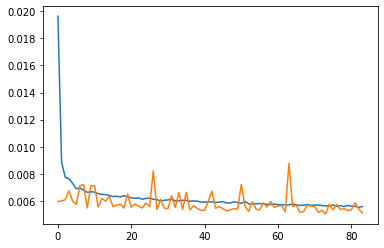

In [226]:
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])

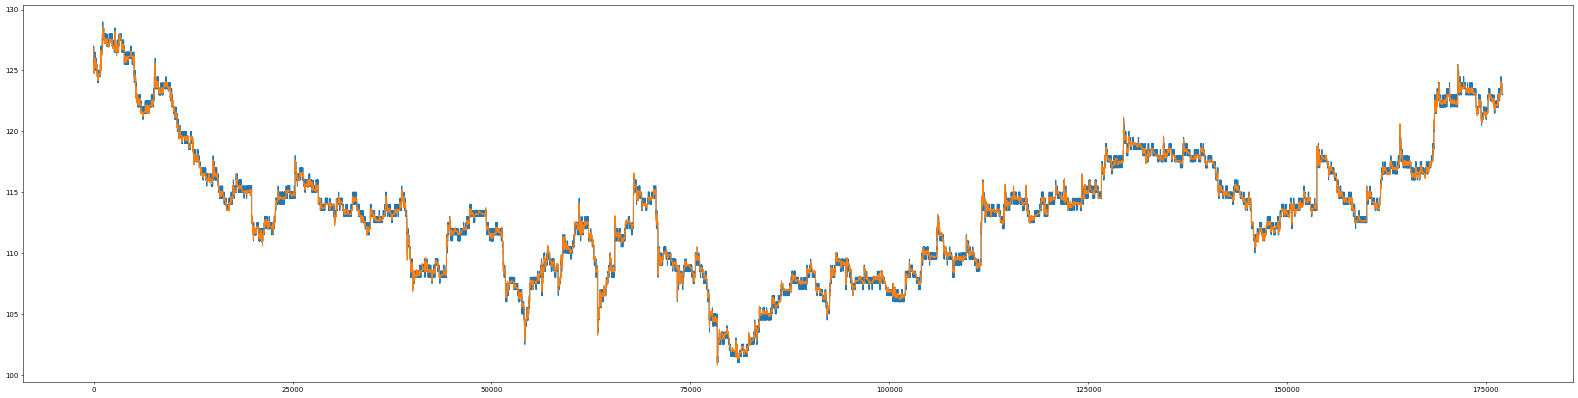

In [228]:
#train error
X_t2 = model_2.predict(X_train2)
plt.figure(figsize=(40,10),dpi=50)
plt.plot(true_range_(df2, Y_train2))
plt.plot(true_range_(df2, X_t2))

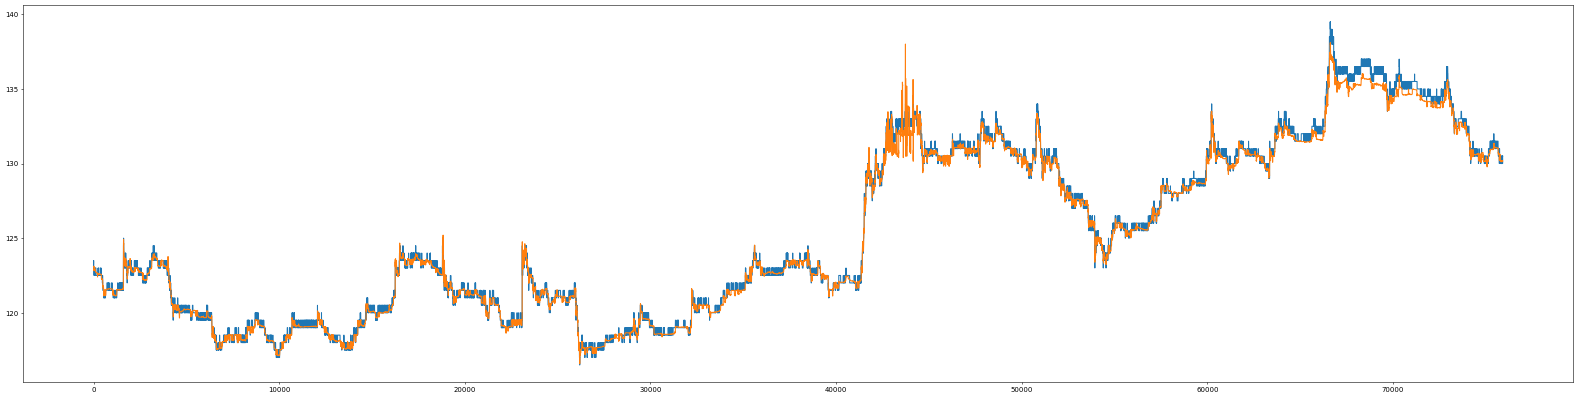

In [229]:
#test error
Xt2 = model_2.predict(X_test2)
plt.figure(figsize=(40,10),dpi=50)
plt.plot(true_range_(df2, Y_test2))
plt.plot(true_range_(df2, Xt2))

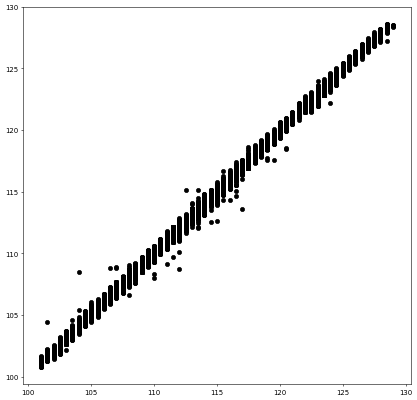

In [230]:
#train error scatter plot
plt.figure(figsize=(10,10),dpi=50)
plt.scatter(true_range_(df2, Y_train2), true_range_(df2, X_t2), color = ['black'])

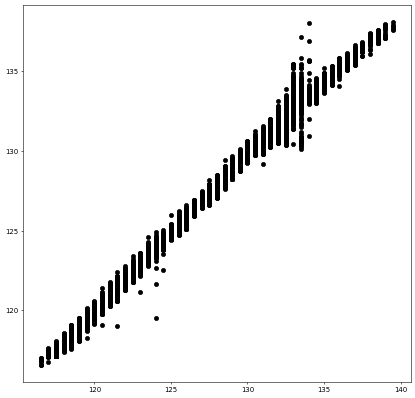

In [232]:
#test error scatter plot
plt.figure(figsize=(10,10),dpi=50)
plt.scatter(true_range_(df2, Y_test2), true_range_(df2, Xt2), color = ['black'])

In [233]:
df2

,DealQty,BidQty1,Bid1,Ask1,AskQty1,BidQty2,Bid2,Ask2,AskQty2,BidQty3,...,daq2_dt,daq3_dt,daq4_dt,daq5_dt,dbq1_dt,dbq2_dt,dbq3_dt,dbq4_dt,dbq5_dt,Price
0,2,60,126.5,127.0,108,78,126.0,127.5,36,53,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,127.0
1,6,62,126.5,127.0,102,79,126.0,127.5,41,53,...,5.0,0.0,0.0,5.0,2.0,1.0,0.0,0.0,5.0,127.0
2,7,63,126.5,127.0,102,78,126.0,127.5,40,53,...,-1.0,0.0,0.0,1.0,1.0,-1.0,0.0,0.0,0.0,127.0
3,7,93,126.5,127.0,103,78,126.0,127.5,41,53,...,1.0,0.0,-1.0,0.0,30.0,0.0,0.0,0.0,0.0,127.0
4,102,92,126.5,127.0,8,78,126.0,127.5,41,59,...,0.0,0.0,0.0,-1.0,-1.0,0.0,6.0,1.0,0.0,127.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253054,1,212,130.0,130.5,22,142,129.5,131.0,24,316,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,130.5
253055,0,213,130.0,130.5,22,142,129.5,131.0,24,316,...,0.0,-4.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.0,130.5
253056,0,213,130.0,130.5,15,142,129.5,131.0,25,312,...,1.0,0.0,-4.0,0.0,0.0,0.0,-4.0,-10.0,1.0,130.5
253057,1,213,130.0,130.5,14,142,129.5,131.0,26,311,...,1.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0,130.5


In [234]:
df_test2 = df2[-round(df2.shape[0]*0.3):]
df_test2

,DealQty,BidQty1,Bid1,Ask1,AskQty1,BidQty2,Bid2,Ask2,AskQty2,BidQty3,...,daq2_dt,daq3_dt,daq4_dt,daq5_dt,dbq1_dt,dbq2_dt,dbq3_dt,dbq4_dt,dbq5_dt,Price
177141,0,59,123.0,123.5,50,140,122.5,124.0,157,125,...,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,123.0
177142,0,60,123.0,123.5,50,140,122.5,124.0,157,125,...,0.0,1.0,-2.0,0.0,1.0,0.0,0.0,0.0,0.0,123.0
177143,0,60,123.0,123.5,50,140,122.5,124.0,158,125,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,123.0
177144,1,59,123.0,123.5,51,140,122.5,124.0,158,125,...,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,123.0
177145,0,60,123.0,123.5,51,140,122.5,124.0,158,125,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,123.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253054,1,212,130.0,130.5,22,142,129.5,131.0,24,316,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,130.5
253055,0,213,130.0,130.5,22,142,129.5,131.0,24,316,...,0.0,-4.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.0,130.5
253056,0,213,130.0,130.5,15,142,129.5,131.0,25,312,...,1.0,0.0,-4.0,0.0,0.0,0.0,-4.0,-10.0,1.0,130.5
253057,1,213,130.0,130.5,14,142,129.5,131.0,26,311,...,1.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0,130.5


In [235]:
df_test2 = df_test2.iloc[11:, :]
df_test2

,DealQty,BidQty1,Bid1,Ask1,AskQty1,BidQty2,Bid2,Ask2,AskQty2,BidQty3,...,daq2_dt,daq3_dt,daq4_dt,daq5_dt,dbq1_dt,dbq2_dt,dbq3_dt,dbq4_dt,dbq5_dt,Price
177152,1,60,123.0,123.5,64,140,122.5,124.0,158,127,...,0.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,0.0,123.5
177153,0,60,123.0,123.5,64,140,122.5,124.0,160,127,...,2.0,0.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,123.5
177154,0,60,123.0,123.5,66,140,122.5,124.0,160,127,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,123.5
177155,0,60,123.0,123.5,66,140,122.5,124.0,160,127,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,123.5
177156,1,59,123.0,123.5,66,143,122.5,124.0,160,127,...,0.0,1.0,0.0,0.0,-1.0,3.0,0.0,0.0,0.0,123.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253054,1,212,130.0,130.5,22,142,129.5,131.0,24,316,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,130.5
253055,0,213,130.0,130.5,22,142,129.5,131.0,24,316,...,0.0,-4.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.0,130.5
253056,0,213,130.0,130.5,15,142,129.5,131.0,25,312,...,1.0,0.0,-4.0,0.0,0.0,0.0,-4.0,-10.0,1.0,130.5
253057,1,213,130.0,130.5,14,142,129.5,131.0,26,311,...,1.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0,130.5


In [238]:
df_test2['pred_price'] = true_range_(df2, Xt2)
df_test2['pred_price_shift'] = df_test2['pred_price'].shift(1)
df_test2

C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,DealQty,BidQty1,Bid1,Ask1,AskQty1,BidQty2,Bid2,Ask2,AskQty2,BidQty3,...,daq4_dt,daq5_dt,dbq1_dt,dbq2_dt,dbq3_dt,dbq4_dt,dbq5_dt,Price,pred_price,pred_price_shift
177152,1,60,123.0,123.5,64,140,122.5,124.0,158,127,...,1.0,0.0,0.0,0.0,2.0,1.0,0.0,123.5,123.105751,NaN
177153,0,60,123.0,123.5,64,140,122.5,124.0,160,127,...,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,123.5,123.101944,123.105751
177154,0,60,123.0,123.5,66,140,122.5,124.0,160,127,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,123.5,123.101151,123.101944
177155,0,60,123.0,123.5,66,140,122.5,124.0,160,127,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,123.5,123.099945,123.101151
177156,1,59,123.0,123.5,66,143,122.5,124.0,160,127,...,0.0,0.0,-1.0,3.0,0.0,0.0,0.0,123.0,123.096527,123.099945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253054,1,212,130.0,130.5,22,142,129.5,131.0,24,316,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,130.5,130.158722,130.165497
253055,0,213,130.0,130.5,22,142,129.5,131.0,24,316,...,0.0,0.0,1.0,0.0,0.0,0.0,-1.0,130.5,130.163757,130.158722
253056,0,213,130.0,130.5,15,142,129.5,131.0,25,312,...,-4.0,0.0,0.0,0.0,-4.0,-10.0,1.0,130.5,130.161194,130.163757
253057,1,213,130.0,130.5,14,142,129.5,131.0,26,311,...,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0,130.5,130.157974,130.161194


In [239]:
df_test2['pred_return'] = (df_test2['pred_price'] / df_test2['pred_price_shift']) - 1
df_test2

C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,DealQty,BidQty1,Bid1,Ask1,AskQty1,BidQty2,Bid2,Ask2,AskQty2,BidQty3,...,daq5_dt,dbq1_dt,dbq2_dt,dbq3_dt,dbq4_dt,dbq5_dt,Price,pred_price,pred_price_shift,pred_return
177152,1,60,123.0,123.5,64,140,122.5,124.0,158,127,...,0.0,0.0,0.0,2.0,1.0,0.0,123.5,123.105751,NaN,NaN
177153,0,60,123.0,123.5,64,140,122.5,124.0,160,127,...,0.0,0.0,0.0,0.0,0.0,0.0,123.5,123.101944,123.105751,-0.000031
177154,0,60,123.0,123.5,66,140,122.5,124.0,160,127,...,0.0,0.0,0.0,0.0,0.0,0.0,123.5,123.101151,123.101944,-0.000006
177155,0,60,123.0,123.5,66,140,122.5,124.0,160,127,...,0.0,0.0,0.0,0.0,0.0,0.0,123.5,123.099945,123.101151,-0.000010
177156,1,59,123.0,123.5,66,143,122.5,124.0,160,127,...,0.0,-1.0,3.0,0.0,0.0,0.0,123.0,123.096527,123.099945,-0.000028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253054,1,212,130.0,130.5,22,142,129.5,131.0,24,316,...,0.0,0.0,0.0,0.0,0.0,1.0,130.5,130.158722,130.165497,-0.000052
253055,0,213,130.0,130.5,22,142,129.5,131.0,24,316,...,0.0,1.0,0.0,0.0,0.0,-1.0,130.5,130.163757,130.158722,0.000039
253056,0,213,130.0,130.5,15,142,129.5,131.0,25,312,...,0.0,0.0,0.0,-4.0,-10.0,1.0,130.5,130.161194,130.163757,-0.000020
253057,1,213,130.0,130.5,14,142,129.5,131.0,26,311,...,0.0,0.0,0.0,-1.0,0.0,-1.0,130.5,130.157974,130.161194,-0.000025


In [240]:
df_test2['Price_shift'] = df_test2['Price'].shift(1)
df_test2['actual_return'] = (df_test2['Price'] / df_test2['Price_shift']) - 1
df_test2 = df_test2.reset_index(drop = True)
df_test2

C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,DealQty,BidQty1,Bid1,Ask1,AskQty1,BidQty2,Bid2,Ask2,AskQty2,BidQty3,...,dbq2_dt,dbq3_dt,dbq4_dt,dbq5_dt,Price,pred_price,pred_price_shift,pred_return,Price_shift,actual_return
0,1,60,123.0,123.5,64,140,122.5,124.0,158,127,...,0.0,2.0,1.0,0.0,123.5,123.105751,NaN,NaN,NaN,NaN
1,0,60,123.0,123.5,64,140,122.5,124.0,160,127,...,0.0,0.0,0.0,0.0,123.5,123.101944,123.105751,-0.000031,123.5,0.000000
2,0,60,123.0,123.5,66,140,122.5,124.0,160,127,...,0.0,0.0,0.0,0.0,123.5,123.101151,123.101944,-0.000006,123.5,0.000000
3,0,60,123.0,123.5,66,140,122.5,124.0,160,127,...,0.0,0.0,0.0,0.0,123.5,123.099945,123.101151,-0.000010,123.5,0.000000
4,1,59,123.0,123.5,66,143,122.5,124.0,160,127,...,3.0,0.0,0.0,0.0,123.0,123.096527,123.099945,-0.000028,123.5,-0.004049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75902,1,212,130.0,130.5,22,142,129.5,131.0,24,316,...,0.0,0.0,0.0,1.0,130.5,130.158722,130.165497,-0.000052,130.0,0.003846
75903,0,213,130.0,130.5,22,142,129.5,131.0,24,316,...,0.0,0.0,0.0,-1.0,130.5,130.163757,130.158722,0.000039,130.5,0.000000
75904,0,213,130.0,130.5,15,142,129.5,131.0,25,312,...,0.0,-4.0,-10.0,1.0,130.5,130.161194,130.163757,-0.000020,130.5,0.000000
75905,1,213,130.0,130.5,14,142,129.5,131.0,26,311,...,0.0,-1.0,0.0,-1.0,130.5,130.157974,130.161194,-0.000025,130.5,0.000000


In [341]:
df = pd.read_csv('./data/3227.csv')
df['spread1'] = df['Ask1'] - df['Bid1']
df['spread2'] = df['Ask2'] - df['Bid2']
df['spread3'] = df['Ask3'] - df['Bid3']
df['spread4'] = df['Ask4'] - df['Bid4']
df['spread5'] = df['Ask5'] - df['Bid5']
df['mid1'] = (df['Ask1'] + df['Bid1']) / 2
df['mid2'] = (df['Ask2'] + df['Bid2']) / 2
df['mid3'] = (df['Ask3'] + df['Bid3']) / 2
df['mid4'] = (df['Ask4'] + df['Bid4']) / 2
df['mid5'] = (df['Ask5'] + df['Bid5']) / 2
df['a51_diff'] = df['Ask5'] - df['Ask1']
df['b15_diff'] = df['Bid1'] - df['Bid5']
df['a21_diff_abs'] = np.abs(df['Ask2'] - df['Ask1'])
df['a32_diff_abs'] = np.abs(df['Ask2'] - df['Ask1'])
df['a43_diff_abs'] = np.abs(df['Ask2'] - df['Ask1'])
df['a54_diff_abs'] = np.abs(df['Ask2'] - df['Ask1'])
df['b21_diff_abs'] = np.abs(df['Bid2'] - df['Bid1'])
df['b32_diff_abs'] = np.abs(df['Bid3'] - df['Bid2'])
df['b43_diff_abs'] = np.abs(df['Bid4'] - df['Bid3'])
df['b54_diff_abs'] = np.abs(df['Bid5'] - df['Bid4'])
df['a_mean'] = (df['Ask1'] +df['Ask2'] +df['Ask3'] +df['Ask4'] +df['Ask5']) / 5
df['b_mean'] = (df['Bid1'] +df['Bid2'] +df['Bid3'] +df['Bid4'] +df['Bid5']) / 5
df['aq_mean'] = (df['AskQty1'] +df['AskQty2'] +df['AskQty3'] +df['AskQty4'] +df['AskQty5']) / 5
df['bq_mean'] = (df['BidQty1'] +df['BidQty2'] +df['BidQty3'] +df['BidQty4'] +df['BidQty5']) / 5
df['p_acc_diff'] = (df['Ask1'] - df['Bid1']) + (df['Ask1'] - df['Bid1']) +(df['Ask2'] - df['Bid2']) + (df['Ask3'] - df['Bid3']) + (df['Ask4'] - df['Bid4']) + (df['Ask5'] - df['Bid5'])
df['q_acc_diff'] = (df['AskQty1'] - df['BidQty1']) + (df['AskQty1'] - df['BidQty1']) +(df['AskQty2'] - df['BidQty2']) + (df['AskQty3'] - df['BidQty3']) + (df['AskQty4'] - df['BidQty4']) + (df['AskQty5'] - df['BidQty5'])
df['da1_dt'] = df['Ask1'] - df['Ask1'].shift(1)
df['da2_dt'] = df['Ask2'] - df['Ask2'].shift(1)
df['da3_dt'] = df['Ask3'] - df['Ask3'].shift(1)
df['da4_dt'] = df['Ask4'] - df['Ask4'].shift(1)
df['da5_dt'] = df['Ask5'] - df['Ask5'].shift(1)
df['db1_dt'] = df['Bid1'] - df['Bid1'].shift(1)
df['db2_dt'] = df['Bid2'] - df['Bid2'].shift(1)
df['db3_dt'] = df['Bid3'] - df['Bid3'].shift(1)
df['db4_dt'] = df['Bid4'] - df['Bid4'].shift(1)
df['db5_dt'] = df['Bid5'] - df['Bid5'].shift(1)
df['daq1_dt'] = df['AskQty1'] - df['AskQty1'].shift(1)
df['daq2_dt'] = df['AskQty2'] - df['AskQty2'].shift(1)
df['daq3_dt'] = df['AskQty3'] - df['AskQty3'].shift(1)
df['daq4_dt'] = df['AskQty4'] - df['AskQty4'].shift(1)
df['daq5_dt'] = df['AskQty5'] - df['AskQty5'].shift(1)
df['dbq1_dt'] = df['BidQty1'] - df['BidQty1'].shift(1)
df['dbq2_dt'] = df['BidQty2'] - df['BidQty2'].shift(1)
df['dbq3_dt'] = df['BidQty3'] - df['BidQty3'].shift(1)
df['dbq4_dt'] = df['BidQty4'] - df['BidQty4'].shift(1)
df['dbq5_dt'] = df['BidQty5'] - df['BidQty5'].shift(1)
df

,TxTime,Pid,DealPrice,DealQty,BidQty1,Bid1,Ask1,AskQty1,BidQty2,Bid2,...,daq1_dt,daq2_dt,daq3_dt,daq4_dt,daq5_dt,dbq1_dt,dbq2_dt,dbq3_dt,dbq4_dt,dbq5_dt
0,2019/7/1 09:00,3227,126.5,216,60,126.5,127.0,110,78,126.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019/7/1 09:00,3227,127.0,2,60,126.5,127.0,108,78,126.0,...,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2019/7/1 09:00,3227,127.0,6,62,126.5,127.0,102,79,126.0,...,-6.0,5.0,0.0,0.0,5.0,2.0,1.0,0.0,0.0,5.0
3,2019/7/1 09:00,3227,127.0,7,63,126.5,127.0,102,78,126.0,...,0.0,-1.0,0.0,0.0,1.0,1.0,-1.0,0.0,0.0,0.0
4,2019/7/1 09:00,3227,127.0,7,93,126.5,127.0,103,78,126.0,...,1.0,1.0,0.0,-1.0,0.0,30.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253055,2019/11/29 13:24,3227,130.5,1,212,130.0,130.5,22,142,129.5,...,-1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
253056,2019/11/29 13:24,3227,0.0,0,213,130.0,130.5,22,142,129.5,...,0.0,0.0,-4.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.0
253057,2019/11/29 13:24,3227,0.0,0,213,130.0,130.5,15,142,129.5,...,-7.0,1.0,0.0,-4.0,0.0,0.0,0.0,-4.0,-10.0,1.0
253058,2019/11/29 13:24,3227,130.5,1,213,130.0,130.5,14,142,129.5,...,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0


In [342]:
df = df.drop(['Pid'], axis = 1)
df = df.drop([0])
df = df.reset_index(drop = True)
df = df.drop(['b21_diff_abs'], axis = 1)
df

,TxTime,DealPrice,DealQty,BidQty1,Bid1,Ask1,AskQty1,BidQty2,Bid2,Ask2,...,daq1_dt,daq2_dt,daq3_dt,daq4_dt,daq5_dt,dbq1_dt,dbq2_dt,dbq3_dt,dbq4_dt,dbq5_dt
0,2019/7/1 09:00,127.0,2,60,126.5,127.0,108,78,126.0,127.5,...,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2019/7/1 09:00,127.0,6,62,126.5,127.0,102,79,126.0,127.5,...,-6.0,5.0,0.0,0.0,5.0,2.0,1.0,0.0,0.0,5.0
2,2019/7/1 09:00,127.0,7,63,126.5,127.0,102,78,126.0,127.5,...,0.0,-1.0,0.0,0.0,1.0,1.0,-1.0,0.0,0.0,0.0
3,2019/7/1 09:00,127.0,7,93,126.5,127.0,103,78,126.0,127.5,...,1.0,1.0,0.0,-1.0,0.0,30.0,0.0,0.0,0.0,0.0
4,2019/7/1 09:01,127.0,102,92,126.5,127.0,8,78,126.0,127.5,...,-95.0,0.0,0.0,0.0,-1.0,-1.0,0.0,6.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253054,2019/11/29 13:24,130.5,1,212,130.0,130.5,22,142,129.5,131.0,...,-1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
253055,2019/11/29 13:24,0.0,0,213,130.0,130.5,22,142,129.5,131.0,...,0.0,0.0,-4.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.0
253056,2019/11/29 13:24,0.0,0,213,130.0,130.5,15,142,129.5,131.0,...,-7.0,1.0,0.0,-4.0,0.0,0.0,0.0,-4.0,-10.0,1.0
253057,2019/11/29 13:24,130.5,1,213,130.0,130.5,14,142,129.5,131.0,...,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0


In [343]:
df['Price'] = df['DealPrice']
idx = [i for i, e in enumerate(df['Price']) if e == 0]
for i in idx:
    df['Price'].iloc[i] = df['Price'].iloc[i - 1]
df = df.drop(['DealPrice'], axis = 1)
df

C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,TxTime,DealQty,BidQty1,Bid1,Ask1,AskQty1,BidQty2,Bid2,Ask2,AskQty2,...,daq2_dt,daq3_dt,daq4_dt,daq5_dt,dbq1_dt,dbq2_dt,dbq3_dt,dbq4_dt,dbq5_dt,Price
0,2019/7/1 09:00,2,60,126.5,127.0,108,78,126.0,127.5,36,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,127.0
1,2019/7/1 09:00,6,62,126.5,127.0,102,79,126.0,127.5,41,...,5.0,0.0,0.0,5.0,2.0,1.0,0.0,0.0,5.0,127.0
2,2019/7/1 09:00,7,63,126.5,127.0,102,78,126.0,127.5,40,...,-1.0,0.0,0.0,1.0,1.0,-1.0,0.0,0.0,0.0,127.0
3,2019/7/1 09:00,7,93,126.5,127.0,103,78,126.0,127.5,41,...,1.0,0.0,-1.0,0.0,30.0,0.0,0.0,0.0,0.0,127.0
4,2019/7/1 09:01,102,92,126.5,127.0,8,78,126.0,127.5,41,...,0.0,0.0,0.0,-1.0,-1.0,0.0,6.0,1.0,0.0,127.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253054,2019/11/29 13:24,1,212,130.0,130.5,22,142,129.5,131.0,24,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,130.5
253055,2019/11/29 13:24,0,213,130.0,130.5,22,142,129.5,131.0,24,...,0.0,-4.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.0,130.5
253056,2019/11/29 13:24,0,213,130.0,130.5,15,142,129.5,131.0,25,...,1.0,0.0,-4.0,0.0,0.0,0.0,-4.0,-10.0,1.0,130.5
253057,2019/11/29 13:24,1,213,130.0,130.5,14,142,129.5,131.0,26,...,1.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0,130.5


In [351]:
str(df['TxTime'].iloc[1])[0:8]

'2019/7/1'

In [355]:
from datetime import datetime
df['TxTime'] = pd.to_datetime(df['TxTime'])
df

,TxTime,DealQty,BidQty1,Bid1,Ask1,AskQty1,BidQty2,Bid2,Ask2,AskQty2,...,daq2_dt,daq3_dt,daq4_dt,daq5_dt,dbq1_dt,dbq2_dt,dbq3_dt,dbq4_dt,dbq5_dt,Price
0,2019-07-01 09:00:00,2,60,126.5,127.0,108,78,126.0,127.5,36,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,127.0
1,2019-07-01 09:00:00,6,62,126.5,127.0,102,79,126.0,127.5,41,...,5.0,0.0,0.0,5.0,2.0,1.0,0.0,0.0,5.0,127.0
2,2019-07-01 09:00:00,7,63,126.5,127.0,102,78,126.0,127.5,40,...,-1.0,0.0,0.0,1.0,1.0,-1.0,0.0,0.0,0.0,127.0
3,2019-07-01 09:00:00,7,93,126.5,127.0,103,78,126.0,127.5,41,...,1.0,0.0,-1.0,0.0,30.0,0.0,0.0,0.0,0.0,127.0
4,2019-07-01 09:01:00,102,92,126.5,127.0,8,78,126.0,127.5,41,...,0.0,0.0,0.0,-1.0,-1.0,0.0,6.0,1.0,0.0,127.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253054,2019-11-29 13:24:00,1,212,130.0,130.5,22,142,129.5,131.0,24,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,130.5
253055,2019-11-29 13:24:00,0,213,130.0,130.5,22,142,129.5,131.0,24,...,0.0,-4.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.0,130.5
253056,2019-11-29 13:24:00,0,213,130.0,130.5,15,142,129.5,131.0,25,...,1.0,0.0,-4.0,0.0,0.0,0.0,-4.0,-10.0,1.0,130.5
253057,2019-11-29 13:24:00,1,213,130.0,130.5,14,142,129.5,131.0,26,...,1.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0,130.5


In [360]:
df['TxTime'] = [str(x)[0:10] for x in df['TxTime']]
df

,TxTime,DealQty,BidQty1,Bid1,Ask1,AskQty1,BidQty2,Bid2,Ask2,AskQty2,...,daq2_dt,daq3_dt,daq4_dt,daq5_dt,dbq1_dt,dbq2_dt,dbq3_dt,dbq4_dt,dbq5_dt,Price
0,2019-07-01,2,60,126.5,127.0,108,78,126.0,127.5,36,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,127.0
1,2019-07-01,6,62,126.5,127.0,102,79,126.0,127.5,41,...,5.0,0.0,0.0,5.0,2.0,1.0,0.0,0.0,5.0,127.0
2,2019-07-01,7,63,126.5,127.0,102,78,126.0,127.5,40,...,-1.0,0.0,0.0,1.0,1.0,-1.0,0.0,0.0,0.0,127.0
3,2019-07-01,7,93,126.5,127.0,103,78,126.0,127.5,41,...,1.0,0.0,-1.0,0.0,30.0,0.0,0.0,0.0,0.0,127.0
4,2019-07-01,102,92,126.5,127.0,8,78,126.0,127.5,41,...,0.0,0.0,0.0,-1.0,-1.0,0.0,6.0,1.0,0.0,127.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253054,2019-11-29,1,212,130.0,130.5,22,142,129.5,131.0,24,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,130.5
253055,2019-11-29,0,213,130.0,130.5,22,142,129.5,131.0,24,...,0.0,-4.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.0,130.5
253056,2019-11-29,0,213,130.0,130.5,15,142,129.5,131.0,25,...,1.0,0.0,-4.0,0.0,0.0,0.0,-4.0,-10.0,1.0,130.5
253057,2019-11-29,1,213,130.0,130.5,14,142,129.5,131.0,26,...,1.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0,130.5


In [362]:
df['TxTime'].unique()[0]

'2019-07-01'

In [363]:
df['equity_value'] = pd.DataFrame(data = np.zeros((len(df), 1)), index = df.index[:])
df

,TxTime,DealQty,BidQty1,Bid1,Ask1,AskQty1,BidQty2,Bid2,Ask2,AskQty2,...,daq3_dt,daq4_dt,daq5_dt,dbq1_dt,dbq2_dt,dbq3_dt,dbq4_dt,dbq5_dt,Price,equity_value
0,2019-07-01,2,60,126.5,127.0,108,78,126.0,127.5,36,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,127.0,0.0
1,2019-07-01,6,62,126.5,127.0,102,79,126.0,127.5,41,...,0.0,0.0,5.0,2.0,1.0,0.0,0.0,5.0,127.0,0.0
2,2019-07-01,7,63,126.5,127.0,102,78,126.0,127.5,40,...,0.0,0.0,1.0,1.0,-1.0,0.0,0.0,0.0,127.0,0.0
3,2019-07-01,7,93,126.5,127.0,103,78,126.0,127.5,41,...,0.0,-1.0,0.0,30.0,0.0,0.0,0.0,0.0,127.0,0.0
4,2019-07-01,102,92,126.5,127.0,8,78,126.0,127.5,41,...,0.0,0.0,-1.0,-1.0,0.0,6.0,1.0,0.0,127.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253054,2019-11-29,1,212,130.0,130.5,22,142,129.5,131.0,24,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,130.5,0.0
253055,2019-11-29,0,213,130.0,130.5,22,142,129.5,131.0,24,...,-4.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.0,130.5,0.0
253056,2019-11-29,0,213,130.0,130.5,15,142,129.5,131.0,25,...,0.0,-4.0,0.0,0.0,0.0,-4.0,-10.0,1.0,130.5,0.0
253057,2019-11-29,1,213,130.0,130.5,14,142,129.5,131.0,26,...,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0,130.5,0.0


In [364]:
df_test = df[-round(df2.shape[0]*0.3):]
df_train = df[:round(df.shape[0]*0.7)]

In [365]:
df_train

,TxTime,DealQty,BidQty1,Bid1,Ask1,AskQty1,BidQty2,Bid2,Ask2,AskQty2,...,daq3_dt,daq4_dt,daq5_dt,dbq1_dt,dbq2_dt,dbq3_dt,dbq4_dt,dbq5_dt,Price,equity_value
0,2019-07-01,2,60,126.5,127.0,108,78,126.0,127.5,36,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,127.0,0.0
1,2019-07-01,6,62,126.5,127.0,102,79,126.0,127.5,41,...,0.0,0.0,5.0,2.0,1.0,0.0,0.0,5.0,127.0,0.0
2,2019-07-01,7,63,126.5,127.0,102,78,126.0,127.5,40,...,0.0,0.0,1.0,1.0,-1.0,0.0,0.0,0.0,127.0,0.0
3,2019-07-01,7,93,126.5,127.0,103,78,126.0,127.5,41,...,0.0,-1.0,0.0,30.0,0.0,0.0,0.0,0.0,127.0,0.0
4,2019-07-01,102,92,126.5,127.0,8,78,126.0,127.5,41,...,0.0,0.0,-1.0,-1.0,0.0,6.0,1.0,0.0,127.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177136,2019-10-23,0,58,123.0,123.5,50,140,122.5,124.0,155,...,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,123.0,0.0
177137,2019-10-23,0,58,123.0,123.5,48,140,122.5,124.0,155,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,123.0,0.0
177138,2019-10-23,0,58,123.0,123.5,50,140,122.5,124.0,156,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,123.0,0.0
177139,2019-10-23,0,58,123.0,123.5,50,140,122.5,124.0,156,...,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,123.0,0.0


In [366]:
df_test

,TxTime,DealQty,BidQty1,Bid1,Ask1,AskQty1,BidQty2,Bid2,Ask2,AskQty2,...,daq3_dt,daq4_dt,daq5_dt,dbq1_dt,dbq2_dt,dbq3_dt,dbq4_dt,dbq5_dt,Price,equity_value
177141,2019-10-23,0,59,123.0,123.5,50,140,122.5,124.0,157,...,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,123.0,0.0
177142,2019-10-23,0,60,123.0,123.5,50,140,122.5,124.0,157,...,1.0,-2.0,0.0,1.0,0.0,0.0,0.0,0.0,123.0,0.0
177143,2019-10-23,0,60,123.0,123.5,50,140,122.5,124.0,158,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,123.0,0.0
177144,2019-10-23,1,59,123.0,123.5,51,140,122.5,124.0,158,...,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,123.0,0.0
177145,2019-10-23,0,60,123.0,123.5,51,140,122.5,124.0,158,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,123.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253054,2019-11-29,1,212,130.0,130.5,22,142,129.5,131.0,24,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,130.5,0.0
253055,2019-11-29,0,213,130.0,130.5,22,142,129.5,131.0,24,...,-4.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.0,130.5,0.0
253056,2019-11-29,0,213,130.0,130.5,15,142,129.5,131.0,25,...,0.0,-4.0,0.0,0.0,0.0,-4.0,-10.0,1.0,130.5,0.0
253057,2019-11-29,1,213,130.0,130.5,14,142,129.5,131.0,26,...,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0,130.5,0.0


In [367]:
df_train = df_train.iloc[11:, :]
df_test = df_test.iloc[11:, :]

In [369]:
df_train['pred_price'] = true_range_(df2, X_t2)
df_train['pred_price_shift'] = df_train['pred_price'].shift(1)
df_test['pred_price'] = true_range_(df2, Xt2)
df_test['pred_price_shift'] = df_test['pred_price'].shift(1)

C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

In [370]:
df_train

,TxTime,DealQty,BidQty1,Bid1,Ask1,AskQty1,BidQty2,Bid2,Ask2,AskQty2,...,daq5_dt,dbq1_dt,dbq2_dt,dbq3_dt,dbq4_dt,dbq5_dt,Price,equity_value,pred_price,pred_price_shift
11,2019-07-01,4,59,126.5,127.0,51,82,126.0,127.5,38,...,1.0,-2.0,2.0,0.0,-2.0,2.0,127.0,0.0,126.850769,NaN
12,2019-07-01,5,74,126.5,127.0,53,83,126.0,127.5,50,...,0.0,15.0,1.0,0.0,0.0,0.0,126.5,0.0,126.798149,126.850769
13,2019-07-01,4,91,126.5,127.0,57,83,126.0,127.5,50,...,0.0,17.0,0.0,0.0,0.0,0.0,126.5,0.0,126.780090,126.798149
14,2019-07-01,5,110,126.5,127.0,66,81,126.0,127.5,51,...,0.0,19.0,-2.0,0.0,1.0,0.0,126.5,0.0,126.748398,126.780090
15,2019-07-01,6,109,126.5,127.0,67,121,126.0,127.5,56,...,1.0,-1.0,40.0,0.0,0.0,0.0,126.5,0.0,126.820534,126.748398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177136,2019-10-23,0,58,123.0,123.5,50,140,122.5,124.0,155,...,0.0,2.0,0.0,0.0,0.0,0.0,123.0,0.0,123.116043,123.114838
177137,2019-10-23,0,58,123.0,123.5,48,140,122.5,124.0,155,...,0.0,0.0,0.0,0.0,0.0,0.0,123.0,0.0,123.115341,123.116043
177138,2019-10-23,0,58,123.0,123.5,50,140,122.5,124.0,156,...,0.0,0.0,0.0,0.0,0.0,0.0,123.0,0.0,123.115479,123.115341
177139,2019-10-23,0,58,123.0,123.5,50,140,122.5,124.0,156,...,0.0,0.0,0.0,0.0,0.0,0.0,123.0,0.0,123.116119,123.115479


In [372]:
X_t2.shape

(177130, 1)

In [373]:
df_test

,TxTime,DealQty,BidQty1,Bid1,Ask1,AskQty1,BidQty2,Bid2,Ask2,AskQty2,...,daq5_dt,dbq1_dt,dbq2_dt,dbq3_dt,dbq4_dt,dbq5_dt,Price,equity_value,pred_price,pred_price_shift
177152,2019-10-23,1,60,123.0,123.5,64,140,122.5,124.0,158,...,0.0,0.0,0.0,2.0,1.0,0.0,123.5,0.0,123.105751,NaN
177153,2019-10-23,0,60,123.0,123.5,64,140,122.5,124.0,160,...,0.0,0.0,0.0,0.0,0.0,0.0,123.5,0.0,123.101944,123.105751
177154,2019-10-23,0,60,123.0,123.5,66,140,122.5,124.0,160,...,0.0,0.0,0.0,0.0,0.0,0.0,123.5,0.0,123.101151,123.101944
177155,2019-10-23,0,60,123.0,123.5,66,140,122.5,124.0,160,...,0.0,0.0,0.0,0.0,0.0,0.0,123.5,0.0,123.099945,123.101151
177156,2019-10-23,1,59,123.0,123.5,66,143,122.5,124.0,160,...,0.0,-1.0,3.0,0.0,0.0,0.0,123.0,0.0,123.096527,123.099945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253054,2019-11-29,1,212,130.0,130.5,22,142,129.5,131.0,24,...,0.0,0.0,0.0,0.0,0.0,1.0,130.5,0.0,130.158722,130.165497
253055,2019-11-29,0,213,130.0,130.5,22,142,129.5,131.0,24,...,0.0,1.0,0.0,0.0,0.0,-1.0,130.5,0.0,130.163757,130.158722
253056,2019-11-29,0,213,130.0,130.5,15,142,129.5,131.0,25,...,0.0,0.0,0.0,-4.0,-10.0,1.0,130.5,0.0,130.161194,130.163757
253057,2019-11-29,1,213,130.0,130.5,14,142,129.5,131.0,26,...,0.0,0.0,0.0,-1.0,0.0,-1.0,130.5,0.0,130.157974,130.161194


In [375]:
Xt2.shape

(75907, 1)

In [376]:
#pred return train
df_train['pred_return'] = (df_train['pred_price'] / df_train['pred_price_shift']) - 1
#pred return test
df_test['pred_return'] = (df_test['pred_price'] / df_test['pred_price_shift']) - 1
#actual return train
df_train['Price_shift'] = df_train['Price'].shift(1)
df_train['actual_return'] = (df_train['Price'] / df_train['Price_shift']) - 1
df_train = df_train.reset_index(drop = True)
#actual return test
df_test['Price_shift'] = df_test['Price'].shift(1)
df_test['actual_return'] = (df_test['Price'] / df_test['Price_shift']) - 1
df_test = df_test.reset_index(drop = True)

C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

In [619]:
#pred return train
df_train['pred_return_2'] = (df_train['pred_price'] / df_train['Price_shift']) - 1
#pred return test
df_test['pred_return_2'] = (df_test['pred_price'] / df_test['Price_shift']) - 1

In [620]:
df_train

,TxTime,DealQty,BidQty1,Bid1,Ask1,AskQty1,BidQty2,Bid2,Ask2,AskQty2,...,dbq5_dt,Price,equity_value,pred_price,pred_price_shift,pred_return,Price_shift,actual_return,side,pred_return_2
0,2019-07-01,5,74,126.5,127.0,53,83,126.0,127.5,50,...,0.0,126.5,0.0,126.798149,126.850769,-0.000415,127.0,-0.003937,0.0,-0.001589
1,2019-07-01,4,91,126.5,127.0,57,83,126.0,127.5,50,...,0.0,126.5,0.0,126.780090,126.798149,-0.000142,126.5,0.000000,0.0,0.002214
2,2019-07-01,5,110,126.5,127.0,66,81,126.0,127.5,51,...,0.0,126.5,0.0,126.748398,126.780090,-0.000250,126.5,0.000000,0.0,0.001964
3,2019-07-01,6,109,126.5,127.0,67,121,126.0,127.5,56,...,0.0,126.5,0.0,126.820534,126.748398,0.000569,126.5,0.000000,0.0,0.002534
4,2019-07-01,12,99,126.5,127.0,74,120,126.0,127.5,56,...,0.0,126.5,0.0,126.668503,126.820534,-0.001199,126.5,0.000000,-1.0,0.001332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177124,2019-10-23,0,58,123.0,123.5,50,140,122.5,124.0,155,...,0.0,123.0,0.0,123.116043,123.114838,0.000010,123.0,0.000000,0.0,0.000943
177125,2019-10-23,0,58,123.0,123.5,48,140,122.5,124.0,155,...,0.0,123.0,0.0,123.115341,123.116043,-0.000006,123.0,0.000000,0.0,0.000938
177126,2019-10-23,0,58,123.0,123.5,50,140,122.5,124.0,156,...,0.0,123.0,0.0,123.115479,123.115341,0.000001,123.0,0.000000,0.0,0.000939
177127,2019-10-23,0,58,123.0,123.5,50,140,122.5,124.0,156,...,0.0,123.0,0.0,123.116119,123.115479,0.000005,123.0,0.000000,0.0,0.000944


In [621]:
df_test

,TxTime,DealQty,BidQty1,Bid1,Ask1,AskQty1,BidQty2,Bid2,Ask2,AskQty2,...,dbq5_dt,Price,equity_value,pred_price,pred_price_shift,pred_return,Price_shift,actual_return,side,pred_return_2
0,2019-10-23,0,60,123.0,123.5,64,140,122.5,124.0,160,...,0.0,123.5,0.0,123.101944,123.105751,-0.000031,123.5,0.000000,0.0,-0.003223
1,2019-10-23,0,60,123.0,123.5,66,140,122.5,124.0,160,...,0.0,123.5,0.0,123.101151,123.101944,-0.000006,123.5,0.000000,0.0,-0.003230
2,2019-10-23,0,60,123.0,123.5,66,140,122.5,124.0,160,...,0.0,123.5,0.0,123.099945,123.101151,-0.000010,123.5,0.000000,0.0,-0.003239
3,2019-10-23,1,59,123.0,123.5,66,143,122.5,124.0,160,...,0.0,123.0,0.0,123.096527,123.099945,-0.000028,123.5,-0.004049,0.0,-0.003267
4,2019-10-23,1,58,123.0,123.5,66,143,122.5,124.0,160,...,0.0,123.0,0.0,123.094963,123.096527,-0.000013,123.0,0.000000,0.0,0.000772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75901,2019-11-29,1,212,130.0,130.5,22,142,129.5,131.0,24,...,1.0,130.5,0.0,130.158722,130.165497,-0.000052,130.0,0.003846,0.0,0.001221
75902,2019-11-29,0,213,130.0,130.5,22,142,129.5,131.0,24,...,-1.0,130.5,0.0,130.163757,130.158722,0.000039,130.5,0.000000,0.0,-0.002577
75903,2019-11-29,0,213,130.0,130.5,15,142,129.5,131.0,25,...,1.0,130.5,0.0,130.161194,130.163757,-0.000020,130.5,0.000000,0.0,-0.002596
75904,2019-11-29,1,213,130.0,130.5,14,142,129.5,131.0,26,...,-1.0,130.5,0.0,130.157974,130.161194,-0.000025,130.5,0.000000,0.0,-0.002621


In [380]:
df_train = df_train.drop([0])
df_train = df_train.reset_index(drop = True)
df_train

,TxTime,DealQty,BidQty1,Bid1,Ask1,AskQty1,BidQty2,Bid2,Ask2,AskQty2,...,dbq3_dt,dbq4_dt,dbq5_dt,Price,equity_value,pred_price,pred_price_shift,pred_return,Price_shift,actual_return
0,2019-07-01,5,74,126.5,127.0,53,83,126.0,127.5,50,...,0.0,0.0,0.0,126.5,0.0,126.798149,126.850769,-0.000415,127.0,-0.003937
1,2019-07-01,4,91,126.5,127.0,57,83,126.0,127.5,50,...,0.0,0.0,0.0,126.5,0.0,126.780090,126.798149,-0.000142,126.5,0.000000
2,2019-07-01,5,110,126.5,127.0,66,81,126.0,127.5,51,...,0.0,1.0,0.0,126.5,0.0,126.748398,126.780090,-0.000250,126.5,0.000000
3,2019-07-01,6,109,126.5,127.0,67,121,126.0,127.5,56,...,0.0,0.0,0.0,126.5,0.0,126.820534,126.748398,0.000569,126.5,0.000000
4,2019-07-01,12,99,126.5,127.0,74,120,126.0,127.5,56,...,30.0,0.0,0.0,126.5,0.0,126.668503,126.820534,-0.001199,126.5,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177124,2019-10-23,0,58,123.0,123.5,50,140,122.5,124.0,155,...,0.0,0.0,0.0,123.0,0.0,123.116043,123.114838,0.000010,123.0,0.000000
177125,2019-10-23,0,58,123.0,123.5,48,140,122.5,124.0,155,...,0.0,0.0,0.0,123.0,0.0,123.115341,123.116043,-0.000006,123.0,0.000000
177126,2019-10-23,0,58,123.0,123.5,50,140,122.5,124.0,156,...,0.0,0.0,0.0,123.0,0.0,123.115479,123.115341,0.000001,123.0,0.000000
177127,2019-10-23,0,58,123.0,123.5,50,140,122.5,124.0,156,...,0.0,0.0,0.0,123.0,0.0,123.116119,123.115479,0.000005,123.0,0.000000


In [381]:
df_test = df_test.drop([0])
df_test = df_test.reset_index(drop = True)
df_test

,TxTime,DealQty,BidQty1,Bid1,Ask1,AskQty1,BidQty2,Bid2,Ask2,AskQty2,...,dbq3_dt,dbq4_dt,dbq5_dt,Price,equity_value,pred_price,pred_price_shift,pred_return,Price_shift,actual_return
0,2019-10-23,0,60,123.0,123.5,64,140,122.5,124.0,160,...,0.0,0.0,0.0,123.5,0.0,123.101944,123.105751,-0.000031,123.5,0.000000
1,2019-10-23,0,60,123.0,123.5,66,140,122.5,124.0,160,...,0.0,0.0,0.0,123.5,0.0,123.101151,123.101944,-0.000006,123.5,0.000000
2,2019-10-23,0,60,123.0,123.5,66,140,122.5,124.0,160,...,0.0,0.0,0.0,123.5,0.0,123.099945,123.101151,-0.000010,123.5,0.000000
3,2019-10-23,1,59,123.0,123.5,66,143,122.5,124.0,160,...,0.0,0.0,0.0,123.0,0.0,123.096527,123.099945,-0.000028,123.5,-0.004049
4,2019-10-23,1,58,123.0,123.5,66,143,122.5,124.0,160,...,0.0,0.0,0.0,123.0,0.0,123.094963,123.096527,-0.000013,123.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75901,2019-11-29,1,212,130.0,130.5,22,142,129.5,131.0,24,...,0.0,0.0,1.0,130.5,0.0,130.158722,130.165497,-0.000052,130.0,0.003846
75902,2019-11-29,0,213,130.0,130.5,22,142,129.5,131.0,24,...,0.0,0.0,-1.0,130.5,0.0,130.163757,130.158722,0.000039,130.5,0.000000
75903,2019-11-29,0,213,130.0,130.5,15,142,129.5,131.0,25,...,-4.0,-10.0,1.0,130.5,0.0,130.161194,130.163757,-0.000020,130.5,0.000000
75904,2019-11-29,1,213,130.0,130.5,14,142,129.5,131.0,26,...,-1.0,0.0,-1.0,130.5,0.0,130.157974,130.161194,-0.000025,130.5,0.000000


In [599]:
df_train['side'] = pd.DataFrame(data = np.zeros((len(df_train), 1)), index = df_train.index[:])
for i in range(len(df_train)):
    if df_train['pred_return'].iloc[i] > long_side[4]:
        df_train['side'].iloc[i] = 1
    elif df_train['pred_return'].iloc[i] < short_side[5]:
        df_train['side'].iloc[i] = -1

C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [582]:
df_test['side'] = pd.DataFrame(data = np.zeros((len(df_test), 1)), index = df_test.index[:])
for i in range(len(df_test)):
    if df_test['pred_return'].iloc[i] > long_side[3]:
        df_test['side'].iloc[i] = 1
    elif df_test['pred_return'].iloc[i] < short_side[6]:
        df_test['side'].iloc[i] = -1

C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [622]:
df_train

,TxTime,DealQty,BidQty1,Bid1,Ask1,AskQty1,BidQty2,Bid2,Ask2,AskQty2,...,dbq5_dt,Price,equity_value,pred_price,pred_price_shift,pred_return,Price_shift,actual_return,side,pred_return_2
0,2019-07-01,5,74,126.5,127.0,53,83,126.0,127.5,50,...,0.0,126.5,0.0,126.798149,126.850769,-0.000415,127.0,-0.003937,0.0,-0.001589
1,2019-07-01,4,91,126.5,127.0,57,83,126.0,127.5,50,...,0.0,126.5,0.0,126.780090,126.798149,-0.000142,126.5,0.000000,0.0,0.002214
2,2019-07-01,5,110,126.5,127.0,66,81,126.0,127.5,51,...,0.0,126.5,0.0,126.748398,126.780090,-0.000250,126.5,0.000000,0.0,0.001964
3,2019-07-01,6,109,126.5,127.0,67,121,126.0,127.5,56,...,0.0,126.5,0.0,126.820534,126.748398,0.000569,126.5,0.000000,0.0,0.002534
4,2019-07-01,12,99,126.5,127.0,74,120,126.0,127.5,56,...,0.0,126.5,0.0,126.668503,126.820534,-0.001199,126.5,0.000000,-1.0,0.001332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177124,2019-10-23,0,58,123.0,123.5,50,140,122.5,124.0,155,...,0.0,123.0,0.0,123.116043,123.114838,0.000010,123.0,0.000000,0.0,0.000943
177125,2019-10-23,0,58,123.0,123.5,48,140,122.5,124.0,155,...,0.0,123.0,0.0,123.115341,123.116043,-0.000006,123.0,0.000000,0.0,0.000938
177126,2019-10-23,0,58,123.0,123.5,50,140,122.5,124.0,156,...,0.0,123.0,0.0,123.115479,123.115341,0.000001,123.0,0.000000,0.0,0.000939
177127,2019-10-23,0,58,123.0,123.5,50,140,122.5,124.0,156,...,0.0,123.0,0.0,123.116119,123.115479,0.000005,123.0,0.000000,0.0,0.000944


In [521]:
np.sum(df_train['side'] == 1)

46

In [522]:
np.sum(df_train['side'] == -1)

23

In [16]:
np.sum(df_train['pred_return_2'] > 0.002)

29306

In [624]:
np.sum(df_train['pred_return_2']  < -0.001)

52641

In [3]:
#df_train.to_csv('./data/train_result.csv')
#df_test.to_csv('./data/test_result.csv')
df_train = pd.read_csv('./data/train_result.csv', index_col = 0)
df_train

,TxTime,DealQty,BidQty1,Bid1,Ask1,AskQty1,BidQty2,Bid2,Ask2,AskQty2,...,dbq5_dt,Price,equity_value,pred_price,pred_price_shift,pred_return,Price_shift,actual_return,side,pred_return_2
0,2019-07-01,5,74,126.5,127.0,53,83,126.0,127.5,50,...,0.0,126.5,0.0,126.798150,126.85077,-0.000415,127.0,-0.003937,-1.0,-0.001589
1,2019-07-01,4,91,126.5,127.0,57,83,126.0,127.5,50,...,0.0,126.5,0.0,126.780090,126.79815,-0.000142,126.5,0.000000,1.0,0.002214
2,2019-07-01,5,110,126.5,127.0,66,81,126.0,127.5,51,...,0.0,126.5,0.0,126.748400,126.78009,-0.000250,126.5,0.000000,0.0,0.001964
3,2019-07-01,6,109,126.5,127.0,67,121,126.0,127.5,56,...,0.0,126.5,0.0,126.820530,126.74840,0.000569,126.5,0.000000,1.0,0.002534
4,2019-07-01,12,99,126.5,127.0,74,120,126.0,127.5,56,...,0.0,126.5,0.0,126.668500,126.82053,-0.001199,126.5,0.000000,0.0,0.001332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177124,2019-10-23,0,58,123.0,123.5,50,140,122.5,124.0,155,...,0.0,123.0,0.0,123.116040,123.11484,0.000010,123.0,0.000000,0.0,0.000943
177125,2019-10-23,0,58,123.0,123.5,48,140,122.5,124.0,155,...,0.0,123.0,0.0,123.115340,123.11604,-0.000006,123.0,0.000000,0.0,0.000938
177126,2019-10-23,0,58,123.0,123.5,50,140,122.5,124.0,156,...,0.0,123.0,0.0,123.115480,123.11534,0.000001,123.0,0.000000,0.0,0.000939
177127,2019-10-23,0,58,123.0,123.5,50,140,122.5,124.0,156,...,0.0,123.0,0.0,123.116120,123.11548,0.000005,123.0,0.000000,0.0,0.000944


In [20]:
#price可能有問題 -> 修正 (when qty = 0)
date_idx = df_train['TxTime'].unique()
real_price = pd.DataFrame()
for k in date_idx:
    df = df_train[df_train.TxTime == k]
    for i in range(len(df)):
        if (i == 0) and (df['DealQty'].iloc[i] == 0) and (df['side'].iloc[i] == 1):
            df['real_price'].iloc[i] = df['Ask1'].iloc[i]
        elif (i == 0) and (df['DealQty'].iloc[i] == 0) and (df['side'].iloc[i] == -1):
            df['real_price'].iloc[i] = df['Bid1'].iloc[i]
        elif (i == (len(df) - 1)) and (df['DealQty'].iloc[i] == 0) and (df['side'])
            
            
            

In [4]:
df_test = pd.read_csv('./data/test_result.csv', index_col = 0)
df_test

,TxTime,DealQty,BidQty1,Bid1,Ask1,AskQty1,BidQty2,Bid2,Ask2,AskQty2,...,dbq5_dt,Price,equity_value,pred_price,pred_price_shift,pred_return,Price_shift,actual_return,side,pred_return_2
0,2019-10-23,0,60,123.0,123.5,64,140,122.5,124.0,160,...,0.0,123.5,0.0,123.101944,123.105750,-0.000031,123.5,0.000000,-1.0,-0.003223
1,2019-10-23,0,60,123.0,123.5,66,140,122.5,124.0,160,...,0.0,123.5,0.0,123.101150,123.101944,-0.000006,123.5,0.000000,-1.0,-0.003230
2,2019-10-23,0,60,123.0,123.5,66,140,122.5,124.0,160,...,0.0,123.5,0.0,123.099945,123.101150,-0.000010,123.5,0.000000,-1.0,-0.003239
3,2019-10-23,1,59,123.0,123.5,66,143,122.5,124.0,160,...,0.0,123.0,0.0,123.096530,123.099945,-0.000028,123.5,-0.004049,-1.0,-0.003267
4,2019-10-23,1,58,123.0,123.5,66,143,122.5,124.0,160,...,0.0,123.0,0.0,123.094960,123.096530,-0.000013,123.0,0.000000,0.0,0.000772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75901,2019-11-29,1,212,130.0,130.5,22,142,129.5,131.0,24,...,1.0,130.5,0.0,130.158720,130.165500,-0.000052,130.0,0.003846,0.0,0.001221
75902,2019-11-29,0,213,130.0,130.5,22,142,129.5,131.0,24,...,-1.0,130.5,0.0,130.163760,130.158720,0.000039,130.5,0.000000,-1.0,-0.002577
75903,2019-11-29,0,213,130.0,130.5,15,142,129.5,131.0,25,...,1.0,130.5,0.0,130.161200,130.163760,-0.000020,130.5,0.000000,-1.0,-0.002596
75904,2019-11-29,1,213,130.0,130.5,14,142,129.5,131.0,26,...,-1.0,130.5,0.0,130.157970,130.161200,-0.000025,130.5,0.000000,-1.0,-0.002621


In [26]:
df_train['Bid1']

0         126.5
1         126.5
2         126.5
3         126.5
4         126.5
          ...  
177124    123.0
177125    123.0
177126    123.0
177127    123.0
177128    123.0
Name: Bid1, Length: 177129, dtype: float64

# main strategy

In [131]:
#setting parameters
long_side, short_side = [0.0035, 0.003, 0.0025, 0.002, 0.0015, 0.001], [-0.0035, -0.003, -0.0025, -0.002, -0.0015, -0.001]
paras = list(itertools.product(long_side, short_side))
paras

[(0.0035, -0.0035),
 (0.0035, -0.003),
 (0.0035, -0.0025),
 (0.0035, -0.002),
 (0.0035, -0.0015),
 (0.0035, -0.001),
 (0.003, -0.0035),
 (0.003, -0.003),
 (0.003, -0.0025),
 (0.003, -0.002),
 (0.003, -0.0015),
 (0.003, -0.001),
 (0.0025, -0.0035),
 (0.0025, -0.003),
 (0.0025, -0.0025),
 (0.0025, -0.002),
 (0.0025, -0.0015),
 (0.0025, -0.001),
 (0.002, -0.0035),
 (0.002, -0.003),
 (0.002, -0.0025),
 (0.002, -0.002),
 (0.002, -0.0015),
 (0.002, -0.001),
 (0.0015, -0.0035),
 (0.0015, -0.003),
 (0.0015, -0.0025),
 (0.0015, -0.002),
 (0.0015, -0.0015),
 (0.0015, -0.001),
 (0.001, -0.0035),
 (0.001, -0.003),
 (0.001, -0.0025),
 (0.001, -0.002),
 (0.001, -0.0015),
 (0.001, -0.001)]

In [47]:
np.sum(df_train['pred_return_2'] > 0.0035)

9931

In [48]:
np.sum(df_train['pred_return_2'] < -0.0035)

10508

In [132]:
paras

[(0.0035, -0.0035),
 (0.0035, -0.003),
 (0.0035, -0.0025),
 (0.0035, -0.002),
 (0.0035, -0.0015),
 (0.0035, -0.001),
 (0.003, -0.0035),
 (0.003, -0.003),
 (0.003, -0.0025),
 (0.003, -0.002),
 (0.003, -0.0015),
 (0.003, -0.001),
 (0.0025, -0.0035),
 (0.0025, -0.003),
 (0.0025, -0.0025),
 (0.0025, -0.002),
 (0.0025, -0.0015),
 (0.0025, -0.001),
 (0.002, -0.0035),
 (0.002, -0.003),
 (0.002, -0.0025),
 (0.002, -0.002),
 (0.002, -0.0015),
 (0.002, -0.001),
 (0.0015, -0.0035),
 (0.0015, -0.003),
 (0.0015, -0.0025),
 (0.0015, -0.002),
 (0.0015, -0.0015),
 (0.0015, -0.001),
 (0.001, -0.0035),
 (0.001, -0.003),
 (0.001, -0.0025),
 (0.001, -0.002),
 (0.001, -0.0015),
 (0.001, -0.001)]

C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-pa

C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-pa

C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-pa

C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-pa

C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-pa

C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-pa

C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-pa

C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\U

C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-pa

C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\U

C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-pa

C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\U

C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-pa

C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\U

C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-pa

C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\U

C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-pa

C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\U

C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-pa

C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\U

C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-pa

C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\U

C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-pa

C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\U

C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-pa

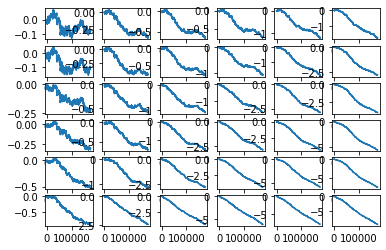

In [135]:
for l in range(len(paras)):
    df_train['side'] = pd.DataFrame(data = np.zeros((len(df_train), 1)), index = df_train.index[:])
    for j in range(len(df_train)):
        if df_train['pred_return_2'].iloc[j] > paras[l][0]:
            df_train['side'].iloc[j] = 1
        elif df_train['pred_return_2'].iloc[j] < paras[l][1]:
            df_train['side'].iloc[j] = -1
    date_idx = df_train['TxTime'].unique()
    equity_value = pd.DataFrame()
    for k in date_idx:
        df = df_train[df_train.TxTime == k]
        side = 0
        for i in range(len(df)):
            #first tick
            if i == 0:
                if df['side'].iloc[i] == 1:
                    side = 1
                    df['mid1'].iloc[i] = df['Ask1'].iloc[i]
                    df['equity_value'].iloc[i] = 0
                elif df['side'].iloc[i] == -1:
                    side = -1
                    df['mid1'].iloc[i] = df['Bid1'].iloc[i]
                    df['equity_value'].iloc[i] = - 0.0015
                else:
                    side = 0
                    df['equity_value'].iloc[i] = 0
            #last tick
            elif i == (len(df) - 1):
                if side == 1:
                    df['equity_value'].iloc[i] = (df['Bid1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1) - 0.0015
                elif side == -1:
                    df['equity_value'].iloc[i] = (df['Ask1'].iloc[i] / df['mid1'].iloc[i-1] - 1) 
                else:
                    df['equity_value'].iloc[i] = 0
            else:
                if (side == 1 and df['side'].iloc[i] == 1) or (side == 1 and df['side'].iloc[i] == 0):
                    side = 1
                    df['equity_value'].iloc[i] = (df['mid1'].iloc[i] / df['mid1'].iloc[i-1] - 1) 
                elif side == 1 and df['side'].iloc[i] == -1:
                    side = 0
                    df['equity_value'].iloc[i] = (df['Bid1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1) - 0.0015
                    df['mid1'].iloc[i] = df['Bid1'].iloc[i]
                elif side == 0 and df['side'].iloc[i] == 0:
                    side = 0
                    df['equity_value'].iloc[i] = 0
                elif side == 0 and df['side'].iloc[i] == 1:
                    side = 1
                    df['equity_value'].iloc[i] = 0
                    df['mid1'].iloc[i] = df['Ask1'].iloc[i]
                elif side == 0 and df['side'].iloc[i] == -1:
                    side = -1
                    df['equity_value'].iloc[i] = - 0.0015
                    df['mid1'].iloc[i] = df['Bid1'].iloc[i]
                elif (side == -1 and df['side'].iloc[i] == 0) or (side == -1 and df['side'].iloc[i] == -1):
                    side = -1
                    df['equity_value'].iloc[i] = (df['mid1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1)
                elif side == -1 and df['side'].iloc[i] == 1:
                    side = 0
                    df['equity_value'].iloc[i] = (df['Ask1'].iloc[i] / df['mid1'].iloc[i-1] - 1)
                    df['mid1'].iloc[i] = df['Ask1'].iloc[i]
        equity_value = pd.concat([equity_value, df[['equity_value']]])
    plt.subplot(6, 6, l+1)
    equity_value_ = np.cumsum(equity_value)
    plt.plot(equity_value_)                    

In [33]:
#test set

In [136]:
paras[0]

(0.0035, -0.0035)

In [137]:
paras[6]

(0.003, -0.0035)

In [141]:
df_test['side'] = pd.DataFrame(data = np.zeros((len(df_test), 1)), index = df_test.index[:])
for i in range(len(df_test)):
    if df_test['pred_return_2'].iloc[i] > paras[6][0]:
        df_test['side'].iloc[i] = 1
    elif df_test['pred_return_2'].iloc[i] < paras[6][1]:
        df_test['side'].iloc[i] = -1

C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [142]:
date_idx = df_test['TxTime'].unique()
equity_value = pd.DataFrame()
for k in date_idx:
    df = df_test[df_test.TxTime == k]
    side = 0
    for i in range(len(df)):
        #first tick
        if i == 0:
            if df['side'].iloc[i] == 1:
                side = 1
                df['mid1'].iloc[i] = df['Ask1'].iloc[i]
                df['equity_value'].iloc[i] = 0
            elif df['side'].iloc[i] == -1:
                side = -1
                df['mid1'].iloc[i] = df['Bid1'].iloc[i]
                df['equity_value'].iloc[i] = - 0.0015
            else:
                side = 0
                df['equity_value'].iloc[i] = 0
        #last tick
        elif i == (len(df) - 1):
            if side == 1:
                df['equity_value'].iloc[i] = (df['Bid1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1) - 0.0015
            elif side == -1:
                df['equity_value'].iloc[i] = (df['Ask1'].iloc[i] / df['mid1'].iloc[i-1] - 1) 
            else:
                df['equity_value'].iloc[i] = 0
        else:
            if (side == 1 and df['side'].iloc[i] == 1) or (side == 1 and df['side'].iloc[i] == 0):
                side = 1
                df['equity_value'].iloc[i] = (df['mid1'].iloc[i] / df['mid1'].iloc[i-1] - 1) 
            elif side == 1 and df['side'].iloc[i] == -1:
                side = 0
                df['equity_value'].iloc[i] = (df['Bid1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1) - 0.0015
                df['mid1'].iloc[i] = df['Bid1'].iloc[i]
            elif side == 0 and df['side'].iloc[i] == 0:
                side = 0
                df['equity_value'].iloc[i] = 0
            elif side == 0 and df['side'].iloc[i] == 1:
                side = 1
                df['equity_value'].iloc[i] = 0
                df['mid1'].iloc[i] = df['Ask1'].iloc[i]
            elif side == 0 and df['side'].iloc[i] == -1:
                side = -1
                df['equity_value'].iloc[i] = - 0.0015
                df['mid1'].iloc[i] = df['Bid1'].iloc[i]
            elif (side == -1 and df['side'].iloc[i] == 0) or (side == -1 and df['side'].iloc[i] == -1):
                side = -1
                df['equity_value'].iloc[i] = (df['mid1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1)
            elif side == -1 and df['side'].iloc[i] == 1:
                side = 0
                df['equity_value'].iloc[i] = (df['Ask1'].iloc[i] / df['mid1'].iloc[i-1] - 1)
                df['mid1'].iloc[i] = df['Ask1'].iloc[i]
    equity_value = pd.concat([equity_value, df[['equity_value']]])

C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-pa

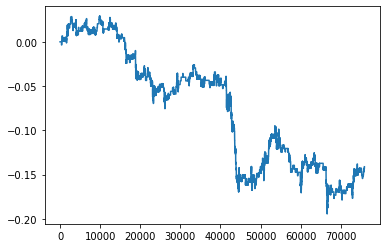

In [140]:
#pred/real(t-1)
#long  + 0.0035
#short - 0.0035
equity_value = np.cumsum(equity_value)
plt.plot(equity_value)

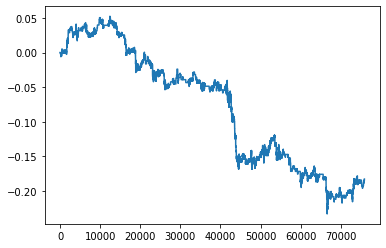

In [143]:
#pred/real(t-1)
#long  + 0.0030
#short - 0.0035
equity_value = np.cumsum(equity_value)
plt.plot(equity_value)